# Presentación



---

*   Desarrollador : Sebastian Kirill Cabrera
*   Intitucion : Coder House
*   Fecha de Entrega : 

En el siguiente infome se estará analizando y desarrollando un modelo de predicción de valores de mercado de vehículos situados en EE.UU.

Este será utilizado como un cotizador para la compra y venta de vehículos.


*   Presentacion
    *   Importar las Librerias y 

## Importar las librerías y obtener datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn") 
import statsmodels.api as sm
import pickle
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV



/Volumes/KINGSTON/Sebastian/DataScience/CoderHouse/ProyectoFinal/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
df = pd.read_csv('/Volumes/KINGSTON/Sebastian/DataScience/CoderHouse/ProyectoFinal/Proyecto/vehicles.csv')
df.columns

KeyboardInterrupt: 

In [ ]:
df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,age
0,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,automatic,NaN,pickup,white,al,7.0
1,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,automatic,NaN,pickup,blue,al,11.0
2,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,automatic,NaN,pickup,red,al,1.0
3,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,automatic,NaN,pickup,red,al,4.0
4,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al,8.0


# Generación de variables

Generamos la variable "age" a partir de la fecha fabricacion del vehículo "year" y su fecha de publicación "posting_date".

In [ ]:
df.posting_date = pd.to_datetime(df['posting_date'], utc = True)

KeyError: 'posting_date'

In [ ]:
df['age'] = df.posting_date.dt.year - df.year

In [ ]:
print(df[df.age == -1]['year'].value_counts())
print(df[df.year == 2022]['year'].count())

2022.0    133
Name: year, dtype: int64
133


Se encuentra un error. Los vehiculos que son fabricados en el año 2022, son publicados en el año 2021.

Tomaremos como dato válido la fecha de publicación.

In [ ]:
df.year = df.year.apply(lambda x : 2021 if x == 2022 else x)

In [ ]:
df['age'] = df.posting_date.dt.year - df.year

In [ ]:
df.shape[0]

426880

In [ ]:
df.dropna(subset = ['manufacturer','price', 'year','model', 'odometer'], inplace = True)

# EDA

## Distribución de variables categóricas

Analizamos todas las variables categóricas nominales y la frecuencia más representativa.

In [ ]:
df[df.dtypes[df.dtypes == 'object'].index.to_list()].describe().T

,count,unique,top,freq
url,399883,399883,https://auburn.craigslist.org/ctd/d/auburn-uni...,1
region,399883,404,columbus,3402
region_url,399883,413,https://kpr.craigslist.org,2881
manufacturer,399883,41,ford,69597
model,399883,23539,f-150,7870
condition,237800,6,good,115129
cylinders,235585,8,6 cylinders,89674
fuel,397874,5,gas,337115
title_status,392710,6,clean,380223
transmission,398275,3,automatic,316997


## Distribución de variables numéricas

Analizamos todas las variables numéricas, sus estadisticas principales.



In [13]:
df[['price','year','odometer','age']].describe().T

,count,mean,std,min,25%,50%,75%,max
price,399883.0,62731.116164,1.130055e+07,0.0,5995.0,13995.0,26590.0,3.736929e+09
year,399883.0,2011.649905,8.574876e+00,1900.0,2009.0,2014.0,2017.0,2.021000e+03
odometer,399883.0,96170.866203,1.898250e+05,0.0,38193.5,85739.0,133008.0,1.000000e+07
age,399883.0,9.350095,8.574876e+00,0.0,4.0,7.0,12.0,1.210000e+02


## Duplicados, Null, Other

### Análisis de Duplicados

In [14]:
df.duplicated().value_counts()/df.shape[0]

False    1.0
dtype: float64

### Análisis de Null

Cantidad absoluta de Null por columna

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 399883 entries, 27 to 426879
Data columns (total 27 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   id            399883 non-null  int64              
 1   url           399883 non-null  object             
 2   region        399883 non-null  object             
 3   region_url    399883 non-null  object             
 4   price         399883 non-null  int64              
 5   year          399883 non-null  float64            
 6   manufacturer  399883 non-null  object             
 7   model         399883 non-null  object             
 8   condition     237800 non-null  object             
 9   cylinders     235585 non-null  object             
 10  fuel          397874 non-null  object             
 11  odometer      399883 non-null  float64            
 12  title_status  392710 non-null  object             
 13  transmission  398275 non-null  object      

Share % de not Null por columna

In [16]:
columns = df.columns.to_list()
for i in columns:
    print(f'{i} : {(df[i].notnull().sum()/df.shape[0])*100}')

id : 100.0
url : 100.0
region : 100.0
region_url : 100.0
price : 100.0
year : 100.0
manufacturer : 100.0
model : 100.0
condition : 59.46739421280724
cylinders : 58.91348219354161
fuel : 99.4976030488918
odometer : 100.0
title_status : 98.20622532090636
transmission : 99.59788238059633
VIN : 63.503324722481324
drive : 70.0997541780971
size : 28.18199323302066
type : 79.18491158663909
paint_color : 70.16177231840314
image_url : 100.0
description : 99.9994998537072
county : 0.0
state : 100.0
lat : 98.4607997839368
long : 98.4607997839368
posting_date : 100.0
age : 100.0


Más del 50% de Null
*   'size'

Más del 40% de Null
*   'condition'
*   'cylinders'

Más del 30% de Null
*   'VIN'
*   'drive'
*   'paint_color'

A lo largo del informe, analizaremos distintos modos de inferir los datos faltantes, además de evaluar la posibilidad de eliminar dichas columnas.

### Análisis de valor 'other'

In [17]:
columns = df.columns.to_list()
for i in columns:
    porcentaje_other = ((df[i] == 'other').sum()/df.shape[0])*100
    print(f'{i} : {porcentaje_other}')

id : 0.0
url : 0.0
region : 0.0
region_url : 0.0
price : 0.0
year : 0.0
manufacturer : 0.0
model : 0.004501316635115772
condition : 0.0
cylinders : 0.22606612434136986
fuel : 7.158843961858843
odometer : 0.0
title_status : 0.0
transmission : 15.00438878371924
VIN : 0.0
drive : 0.0
size : 0.0
type : 5.057479312698964
paint_color : 0.0
image_url : 0.0
description : 0.0
county : 0.0
state : 0.0
lat : 0.0
long : 0.0
posting_date : 0.0
age : 0.0


Se observa que el valor 'other' se repite en varias columnas. Se busca entender el share %.
A medida que el análisis avance, veremos cuán representativo se vuelve este valor con respecto al resto de las variables categóricas, y si podemos inferir su valor.

### Distribución dentro de las variables object.

In [18]:
columns_type_obje = df.dtypes[df.dtypes == 'object'].index.to_list()
for i in columns_type_obje:
    print(i)
    print(df[i].value_counts())
    print(' ')

url
https://auburn.craigslist.org/ctd/d/auburn-university-2014-gmc-sierra-1500/7316814884.html      1
https://nh.craigslist.org/ctd/d/manchester-2020-ford-ranger-supercab-xl/7312865096.html         1
https://nh.craigslist.org/ctd/d/hampstead-2011-chevrolet-silverado-wd/7312808753.html           1
https://nh.craigslist.org/ctd/d/hampstead-2010-chevrolet-silverado-wd/7312808921.html           1
https://nh.craigslist.org/ctd/d/hampstead-2013-chevrolet-silverado-wd/7312809078.html           1
                                                                                               ..
https://decatur.craigslist.org/ctd/d/springfield-2004-chevrolet-corvette/7307932649.html        1
https://decatur.craigslist.org/cto/d/decatur-2oo5-ford-freestar/7308138074.html                 1
https://decatur.craigslist.org/ctd/d/decatur-2016-bmw-series-340i-sedan-4d/7308196492.html      1
https://decatur.craigslist.org/ctd/d/springfield-2018-chevrolet-equinox-lt/7308214490.html      1
https://wyoming.

Podemos observar, de forma absoluta, cuán representativo es el valor 'other' con respecto al resto de variables, destacando las columnas:


*   'type'
*   'transmition'
*   'fuel'

Además, podemos tener una primera impresión de la distribución y frecuencia, para tomar decisiones como descartar columnas del análisis.


#### Elimino las columnas que no son útiles para aplicar a los modelos
* 'url' : de la publicacion del automobil
* 'region_url' : url del site
* 'VIN' : numero del placa 
* 'imagen_url' : url de la imagen del vehiculo
* 'lat' : latitud 
* 'long' : longuitud 

Elimino la latitud y longitud, ya que el dataframe posee otra variable catogórica que me permite realizar una categorización de la ubicación por estados.

In [19]:
drop_columns = ['url', 'region_url', 'VIN', 'image_url', 'lat', 'long','county', 'id', 'posting_date', 'size']
df.drop(columns = drop_columns, inplace = True)

#### Busco si puedo obtener datos faltantes 

In [20]:
values_unique = df[(df['type'] != 'other') & (df['type'].notnull())]['type'].unique().tolist()

In [21]:
th = {}
for j in values_unique:
        th[j] = df['model'].str.contains(j, na = False)
        df.loc[(th[j])&((df['type'].isnull()) | (df['type'] == 'other')), 'type'] = j

El objetivo del apartado es la búsqueda de las variables categóricas dentro de las columnas ['fuel', 'cylinders', 'transmission', 'type'] dentro de cada valor de la columna 'description', con el fin de poder inferir valores Null y other.

In [22]:
lista = ['fuel', 'cylinders', 'transmission', 'type', 'drive']
dic_uniq_value =  dict()
for i in lista:
    values_unique = df[(df[i] != 'other') & (df[i].notnull())][i].unique().tolist()
    dic_uniq_value.update({i : values_unique})

In [23]:
dic_uniq_value

{'fuel': ['gas', 'diesel', 'hybrid', 'electric'],
 'cylinders': ['8 cylinders',
  '6 cylinders',
  '4 cylinders',
  '5 cylinders',
  '10 cylinders',
  '3 cylinders',
  '12 cylinders'],
 'transmission': ['automatic', 'manual'],
 'type': ['pickup',
  'truck',
  'coupe',
  'SUV',
  'hatchback',
  'mini-van',
  'sedan',
  'offroad',
  'van',
  'convertible',
  'wagon',
  'bus'],
 'drive': ['rwd', '4wd', 'fwd']}

In [24]:
dic_uniq_value['drive'].append('awd')
dic_uniq_value['drive'].append('quattro')
dic_uniq_value['type'].append('conv')
dic_uniq_value['type'].append( 'cabriolet')
dic_uniq_value['cylinders'].append('V10')
dic_uniq_value['cylinders'].append('V8')
dic_uniq_value['cylinders'].append('V6')
dic_uniq_value['fuel'].append('tdi')
dic_uniq_value['transmission'].append('mecanic')
dic_uniq_value['transmission'].append('quattro')

Busco datos faltantes (nan, other) de las columnas dic_uniq_values.keys() en la columna description.

#### Description

In [25]:
th = {}
for i in dic_uniq_value.keys():
    th[i] = {}
    for j in dic_uniq_value[i]:
        th[i][j] = df[(df[i].isnull()) | (df[i] == 'other')]['description'].str.contains(j, na = False).map({False : 0, True : 1})

In [26]:
fuel_df = pd.DataFrame(th['fuel'])
fuel_df['mask'] = fuel_df.sum(axis = 1)
fuel_df['diesel'] = fuel_df['diesel'] + fuel_df['tdi']
fuel_df.drop(columns = ['tdi'], inplace = True) 
fuel_df[fuel_df['mask'] > 1] = 0

tran_df = pd.DataFrame(th['transmission'])
tran_df['mask'] = tran_df.sum(axis = 1)
tran_df['automatic'] = tran_df['quattro'] + tran_df['automatic']
tran_df['manual'] = tran_df['mecanic'] + tran_df['manual']
tran_df.drop(columns = ['quattro', 'mecanic'], inplace = True) 
tran_df[tran_df['mask'] > 1] = 0

cyl_df = pd.DataFrame(th['cylinders'])
cyl_df['mask'] = cyl_df.sum(axis = 1)
cyl_df['8 cylinders'] = cyl_df['8 cylinders'] + cyl_df['V8'] 
cyl_df['6 cylinders'] = cyl_df['6 cylinders'] + cyl_df['V6'] 
cyl_df['10 cylinders'] = cyl_df['10 cylinders'] + cyl_df['V10']
cyl_df.drop(columns = ['V8', 'V6', 'V10'], inplace = True) 
cyl_df[cyl_df['mask'] > 1] = 0

type_df = pd.DataFrame(th['type'])
type_df['mask'] = type_df.sum(axis = 1)
type_df['convertible'] = type_df['conv'] + type_df['convertible'] + type_df['cabriolet'] 
type_df.drop(columns = ['cabriolet', 'conv'], inplace = True) 
type_df[type_df['mask'] > 1] = 0

drive_df = pd.DataFrame(th['drive'])
drive_df['mask'] = drive_df.sum(axis = 1)
drive_df['4wd'] = drive_df['4wd'] + drive_df['awd'] 
drive_df.drop(columns = ['awd'], inplace = True) 
drive_df[drive_df['mask'] > 1] = 0

In [27]:
for i in fuel_df.columns:    
    df.loc[(fuel_df[i])&((df['fuel'].isnull()) | (df['fuel'] == 'other')), 'fuel'] = i

for i in tran_df.columns:    
    df.loc[(tran_df[i])&((df['transmission'].isnull()) | (df['transmission'] == 'other')), 'transmission'] = i

for i in cyl_df.columns:    
    df.loc[(cyl_df[i])&((df['cylinders'].isnull()) | (df['cylinders'] == 'other')), 'cylinders'] = i

for i in type_df.columns:    
    df.loc[(type_df[i])&((df['type'].isnull()) | (df['type'] == 'other')), 'type'] = i

for i in drive_df.columns:    
    df.loc[(drive_df[i])&((df['drive'].isnull()) | (df['drive'] == 'other')), 'drive'] = i

In [28]:
print(f"Se pudieron pudieron completar {fuel_df['mask'].sum()} en fuel a partir de lavarialble descrive")
print(f"Se pudieron pudieron completar {tran_df['mask'].sum()} en transmission a partir de lavarialble descrive")
print(f"Se pudieron pudieron completar {cyl_df['mask'].sum()} en cylinders a partir de lavarialble descrive")
print(f"Se pudieron pudieron completar {type_df['mask'].sum()} en type a partir de lavarialble descrive")
print(f"Se pudieron pudieron completar {drive_df['mask'].sum()} en drive a partir de lavarialble descrive")

Se pudieron pudieron completar 1890 en fuel a partir de lavarialble descrive
Se pudieron pudieron completar 54542 en transmission a partir de lavarialble descrive
Se pudieron pudieron completar 44161 en cylinders a partir de lavarialble descrive
Se pudieron pudieron completar 21421 en type a partir de lavarialble descrive
Se pudieron pudieron completar 21080 en drive a partir de lavarialble descrive


#### model

In [29]:
th = {}
for i in dic_uniq_value.keys():
    th[i] = {}
    for j in dic_uniq_value[i]:
        th[i][j] = df[(df[i].isnull()) | (df[i] == 'other')]['model'].str.contains(j, na = False).map({False : 0, True : 1})

In [30]:
fuel_df = pd.DataFrame(th['fuel'])
fuel_df['mask'] = fuel_df.sum(axis = 1)
fuel_df['diesel'] = fuel_df['diesel'] + fuel_df['tdi']
fuel_df.drop(columns = ['tdi'], inplace = True) 
fuel_df[fuel_df['mask'] > 1] = 0

tran_df = pd.DataFrame(th['transmission'])
tran_df['mask'] = tran_df.sum(axis = 1)
tran_df['automatic'] = tran_df['quattro'] + tran_df['automatic']
tran_df['manual'] = tran_df['mecanic'] + tran_df['manual']
tran_df.drop(columns = ['quattro', 'mecanic'], inplace = True) 
tran_df[tran_df['mask'] > 1] = 0

cyl_df = pd.DataFrame(th['cylinders'])
cyl_df['mask'] = cyl_df.sum(axis = 1)
cyl_df['8 cylinders'] = cyl_df['8 cylinders'] + cyl_df['V8'] 
cyl_df['6 cylinders'] = cyl_df['6 cylinders'] + cyl_df['V6'] 
cyl_df['10 cylinders'] = cyl_df['10 cylinders'] + cyl_df['V10']
cyl_df.drop(columns = ['V8', 'V6', 'V10'], inplace = True) 
cyl_df[cyl_df['mask'] > 1] = 0

type_df = pd.DataFrame(th['type'])
type_df['mask'] = type_df.sum(axis = 1)
type_df['convertible'] = type_df['conv'] + type_df['convertible'] + type_df['cabriolet'] 
type_df.drop(columns = ['cabriolet', 'conv'], inplace = True) 
type_df[type_df['mask'] > 1] = 0

drive_df = pd.DataFrame(th['drive'])
drive_df['mask'] = drive_df.sum(axis = 1)
drive_df['4wd'] = drive_df['4wd'] + drive_df['awd']
drive_df['4wd'] = drive_df['4wd'] + drive_df['quattro']  
drive_df.drop(columns = ['awd', 'quattro'], inplace = True) 
drive_df[drive_df['mask'] > 1] = 0

In [31]:
for i in fuel_df.columns:    
    df.loc[(fuel_df[i])&((df['fuel'].isnull()) | (df['fuel'] == 'other')), 'fuel'] = i

for i in tran_df.columns:    
    df.loc[(tran_df[i])&((df['transmission'].isnull()) | (df['transmission'] == 'other')), 'transmission'] = i

for i in cyl_df.columns:    
    df.loc[(cyl_df[i])&((df['cylinders'].isnull()) | (df['cylinders'] == 'other')), 'cylinders'] = i

for i in type_df.columns:    
    df.loc[(type_df[i])&((df['type'].isnull()) | (df['type'] == 'other')), 'type'] = i

for i in drive_df.columns:    
    df.loc[(drive_df[i])&((df['drive'].isnull()) | (df['drive'] == 'other')), 'drive'] = i

Conclusión 

In [32]:
print(f"Se pudieron pudieron completar {fuel_df['mask'].sum()} en fuel a partir de lavarialble descrive")
print(f"Se pudieron pudieron completar {tran_df['mask'].sum()} en transmission a partir de lavarialble descrive")
print(f"Se pudieron pudieron completar {cyl_df['mask'].sum()} en cylinders a partir de lavarialble descrive")
print(f"Se pudieron pudieron completar {type_df['mask'].sum()} en type a partir de lavarialble descrive")

Se pudieron pudieron completar 235 en fuel a partir de lavarialble descrive
Se pudieron pudieron completar 23 en transmission a partir de lavarialble descrive
Se pudieron pudieron completar 0 en cylinders a partir de lavarialble descrive
Se pudieron pudieron completar 35 en type a partir de lavarialble descrive


In [33]:
df.drop(columns=['description'], inplace = True)

## Análisis Univariados

### Funciones Útiles

In [34]:
# -> Diccionario con max, min y np.array booleano de outliers mediante metodo de distancia intercuartilica
def out_dist_interq (lista):
    index_dic = dict()
    for i in lista:
        dist_interq = (df[i].quantile(.75)-df[i].quantile(.25))*1.5
        mask = (df[i]<(df[i].median()+dist_interq)) & (df[i]>(df[i].median()-dist_interq))
        index_dic[i] = {'mask' : mask.values}
        index_dic[i]['max'] = df[mask][i].max()
        index_dic[i]['min'] = df[mask][i].min()
        index_dic[i]['Datos_acumulados'] = df[mask][i].notnull().sum()/df[i].notnull().sum()
        #print(mask.values)
    return index_dic

# -> Diccionario con dataframes de frecuencia absoluta y relativa de cada variable 
def frec (columns):
    d = {}
    for i in columns:
        types_frec = pd.DataFrame()
        types_frec['q'] = df[i].value_counts()
        types_frec['rel'] = df[i].value_counts()/df[i].notnull().sum()
        types_frec['acum'] = df[i].value_counts().cumsum()/df[i].notnull().sum()
        d[i] = types_frec
        del types_frec
    return d

In [35]:
categ_list = df.dtypes[df.dtypes == 'object'].index.to_list()
categ_list.remove('region')
categ_list.remove('model')
df_frec = frec(categ_list)

In [36]:
df_frec.keys()

dict_keys(['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state'])

In [37]:
index_dic = out_dist_interq(['year','price', 'odometer'])

### Categóricas

**----------**
Columan : manufacturer


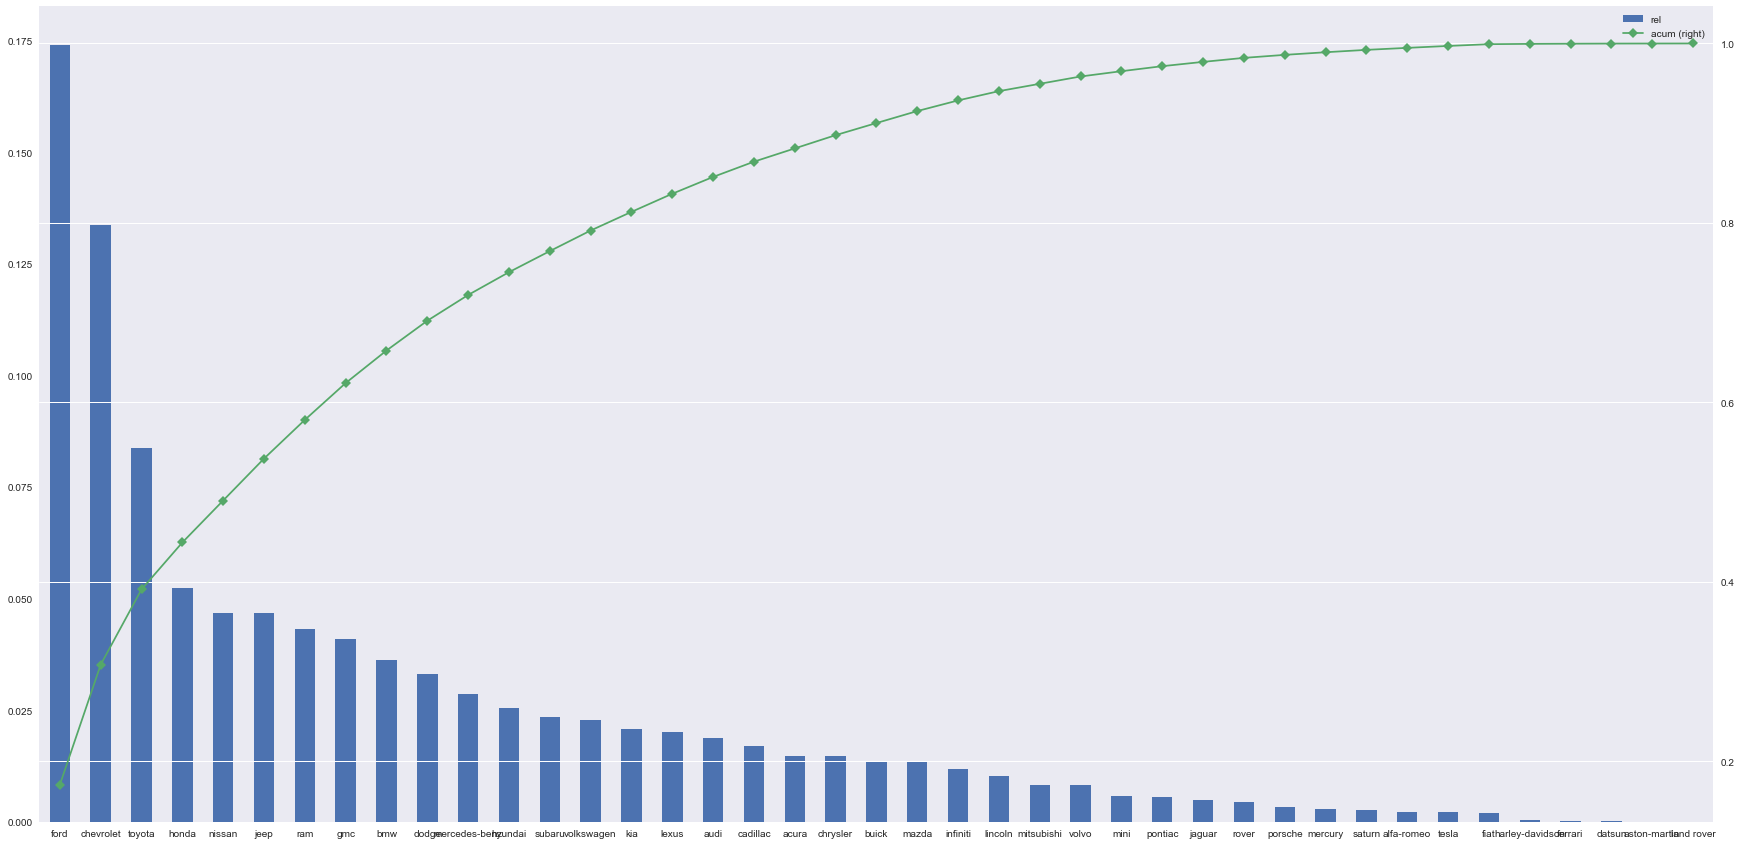

**----------**
Columan : condition


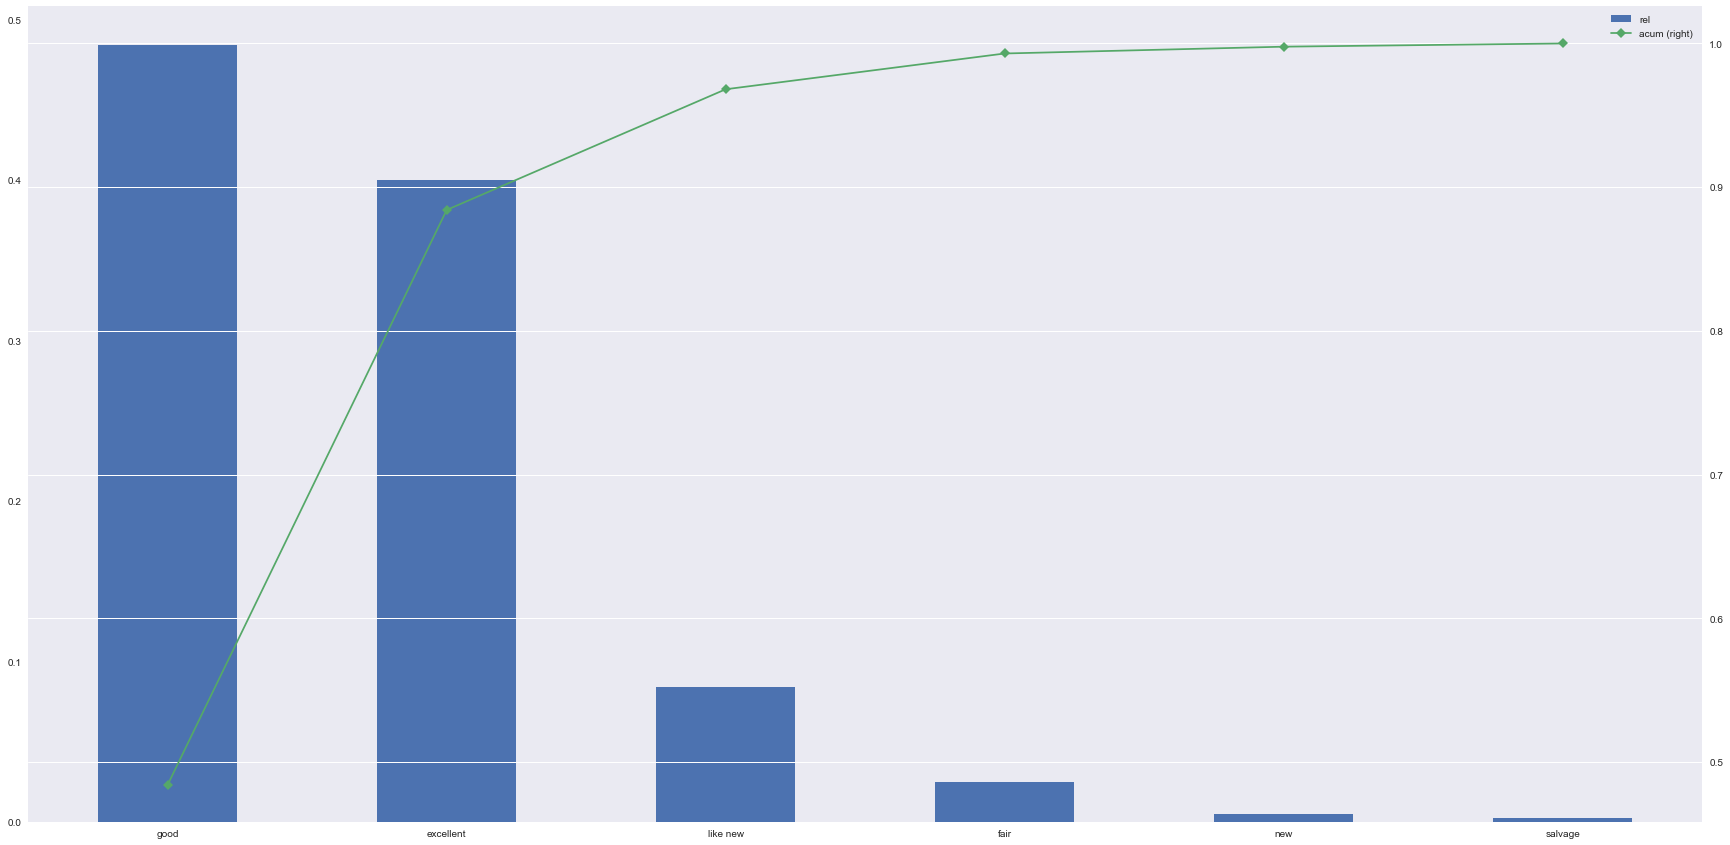

**----------**
Columan : cylinders


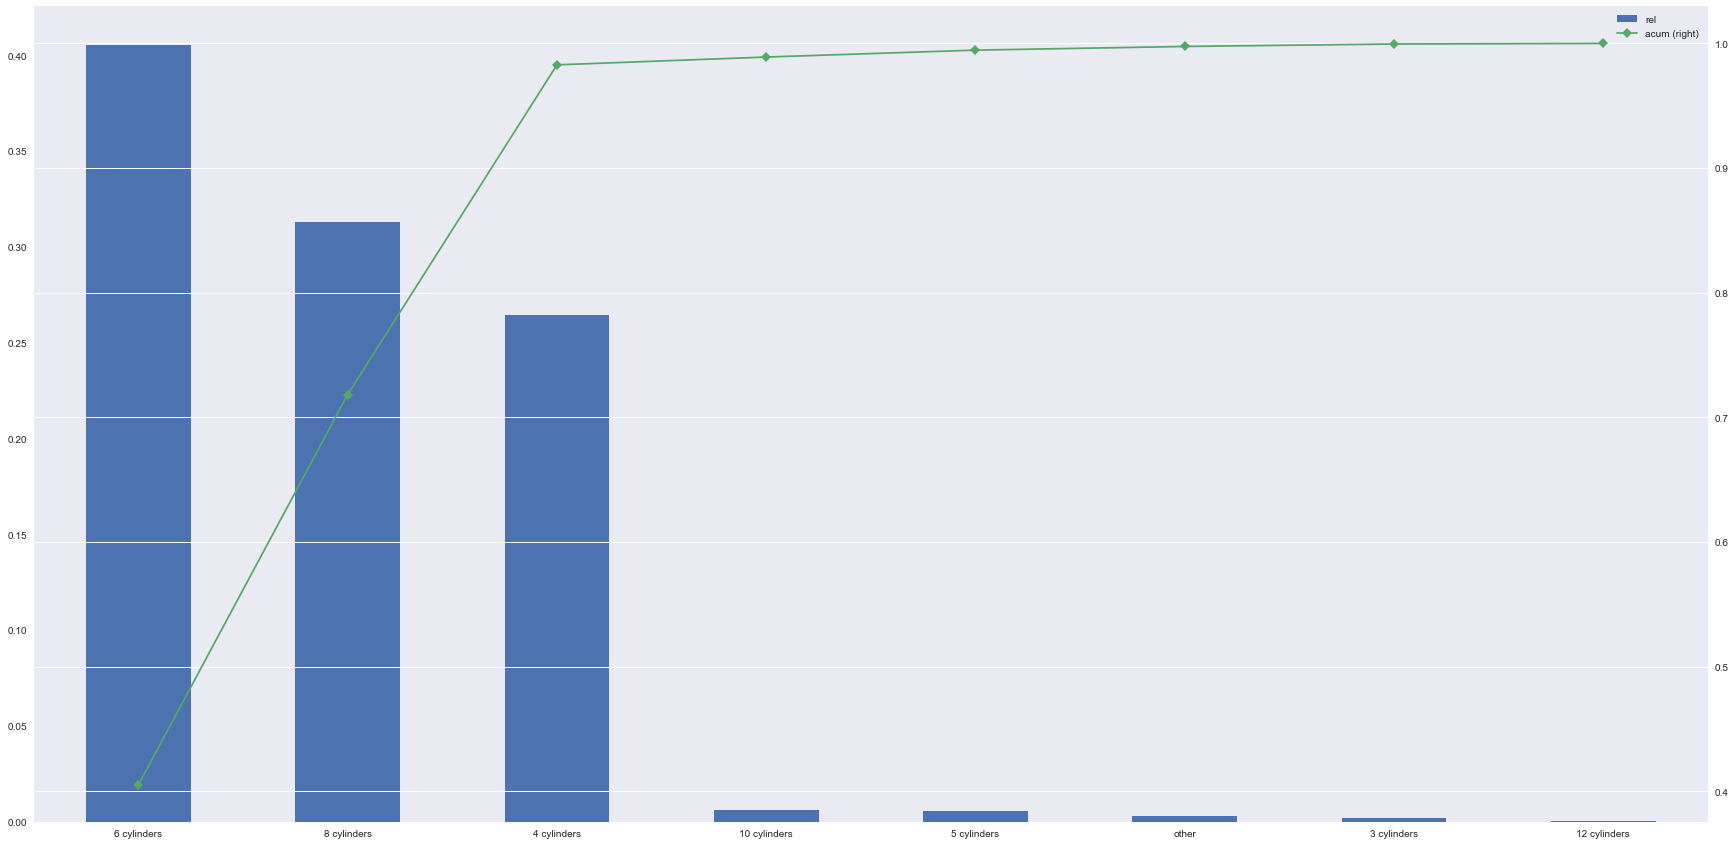

**----------**
Columan : fuel


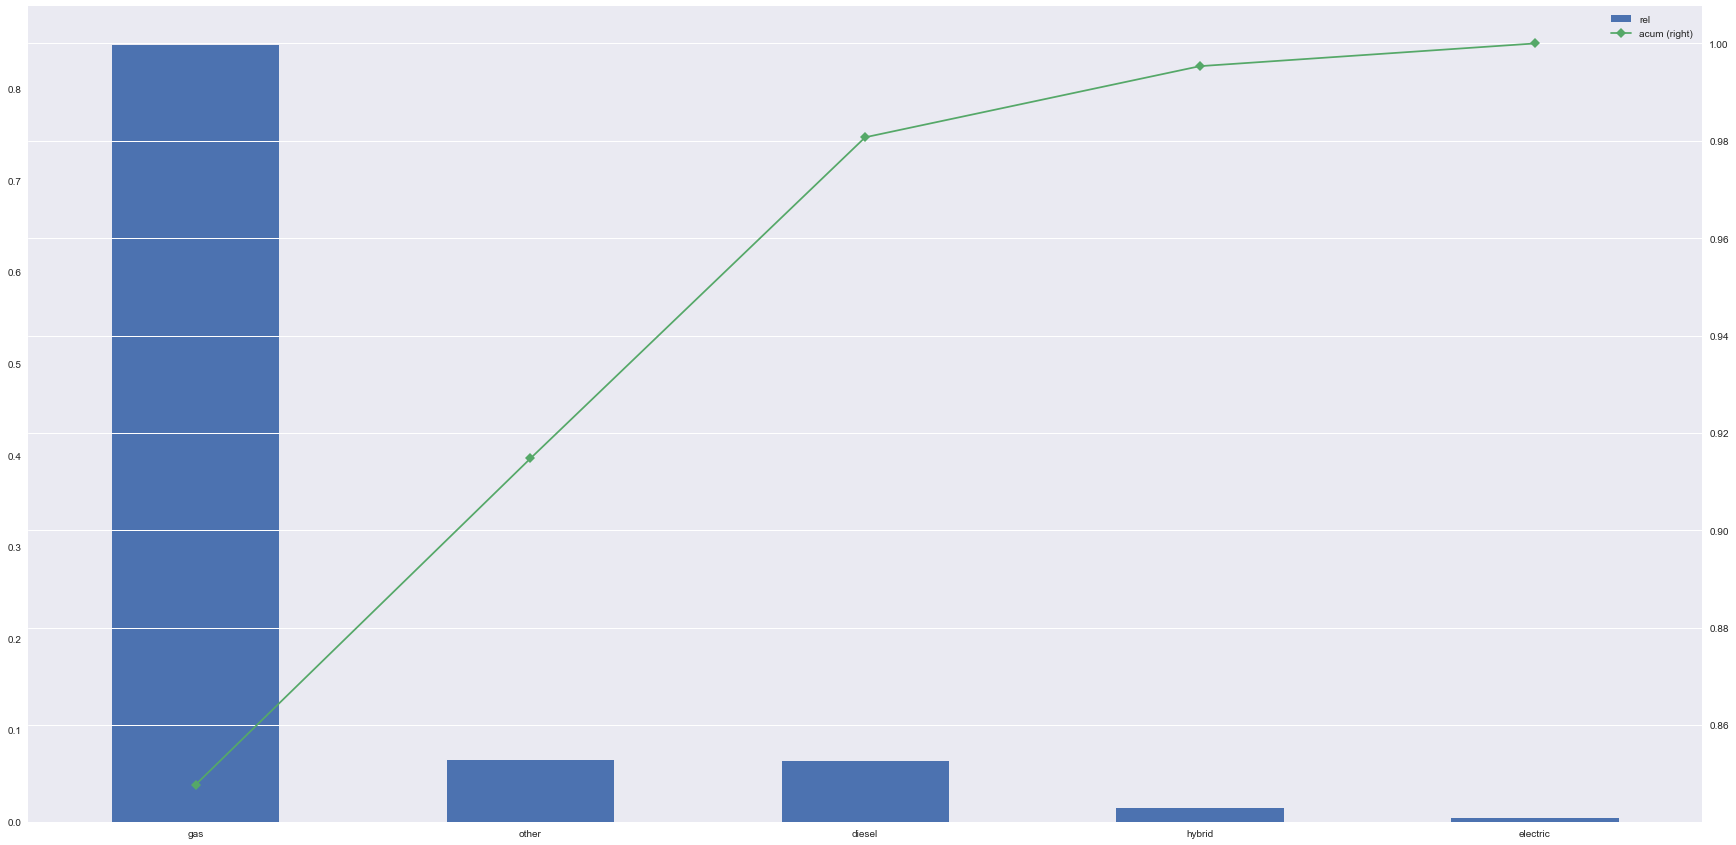

**----------**
Columan : title_status


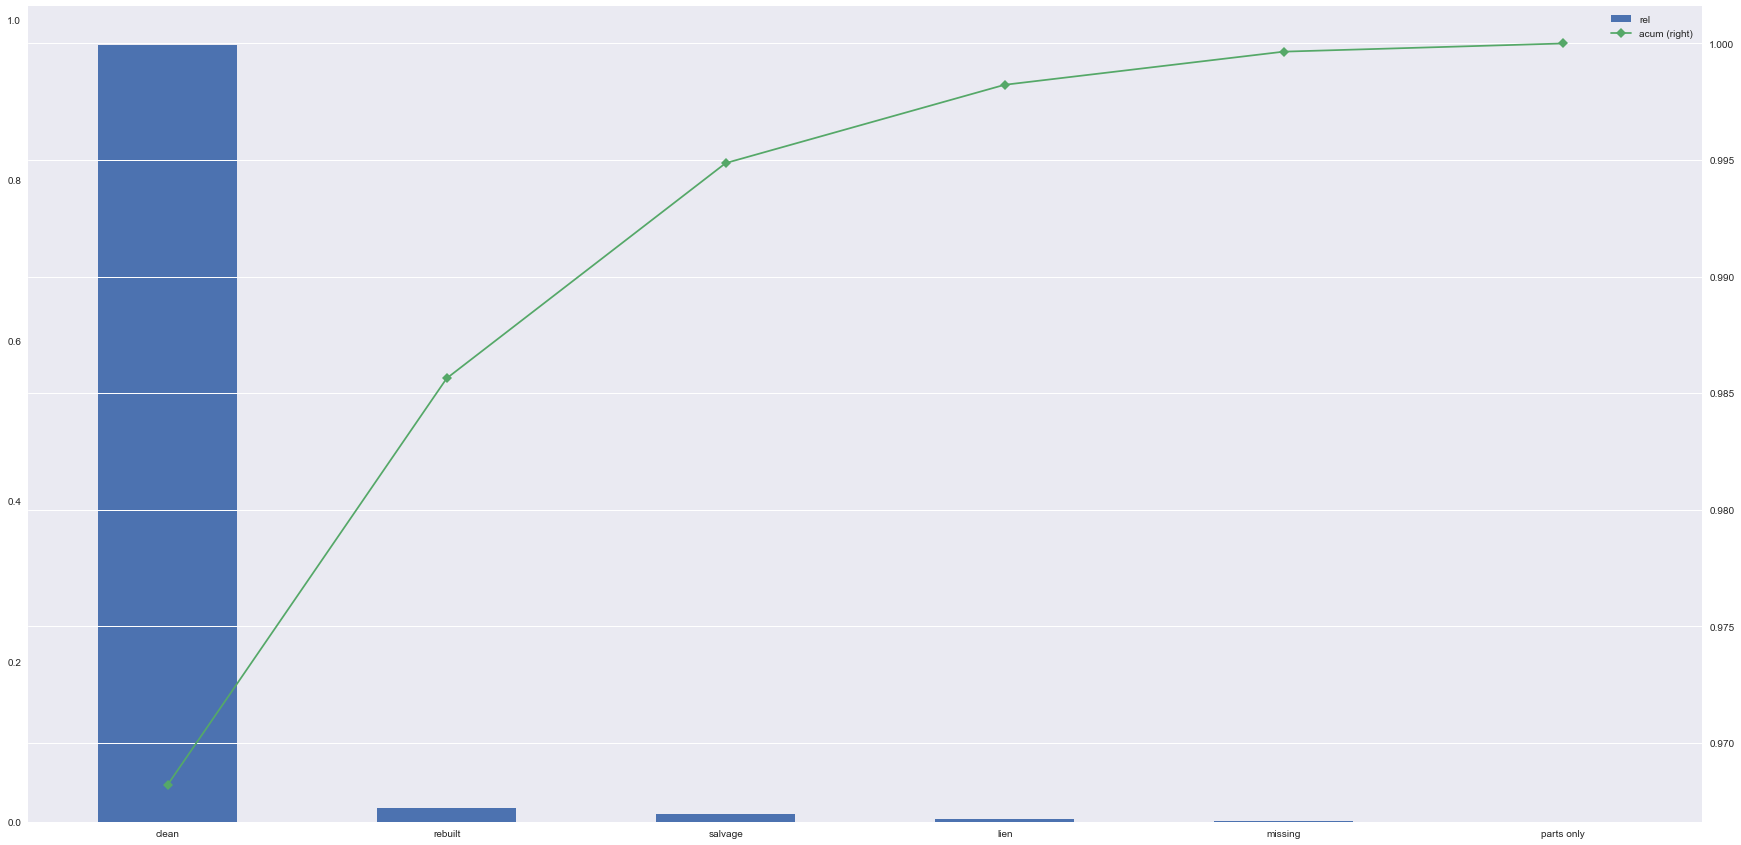

**----------**
Columan : transmission


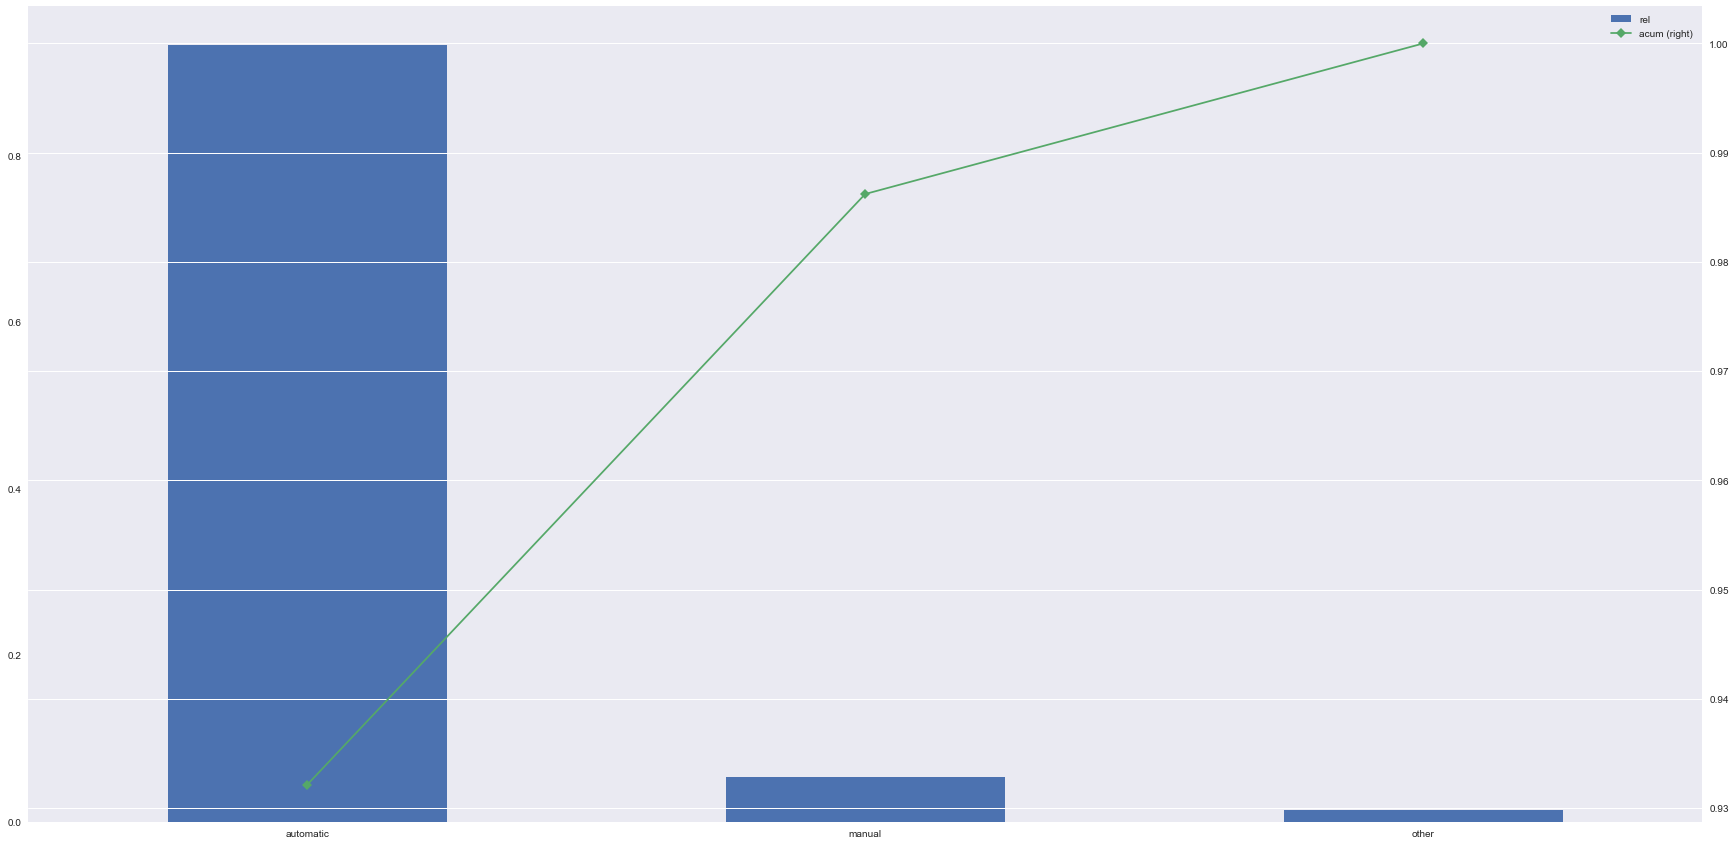

**----------**
Columan : drive


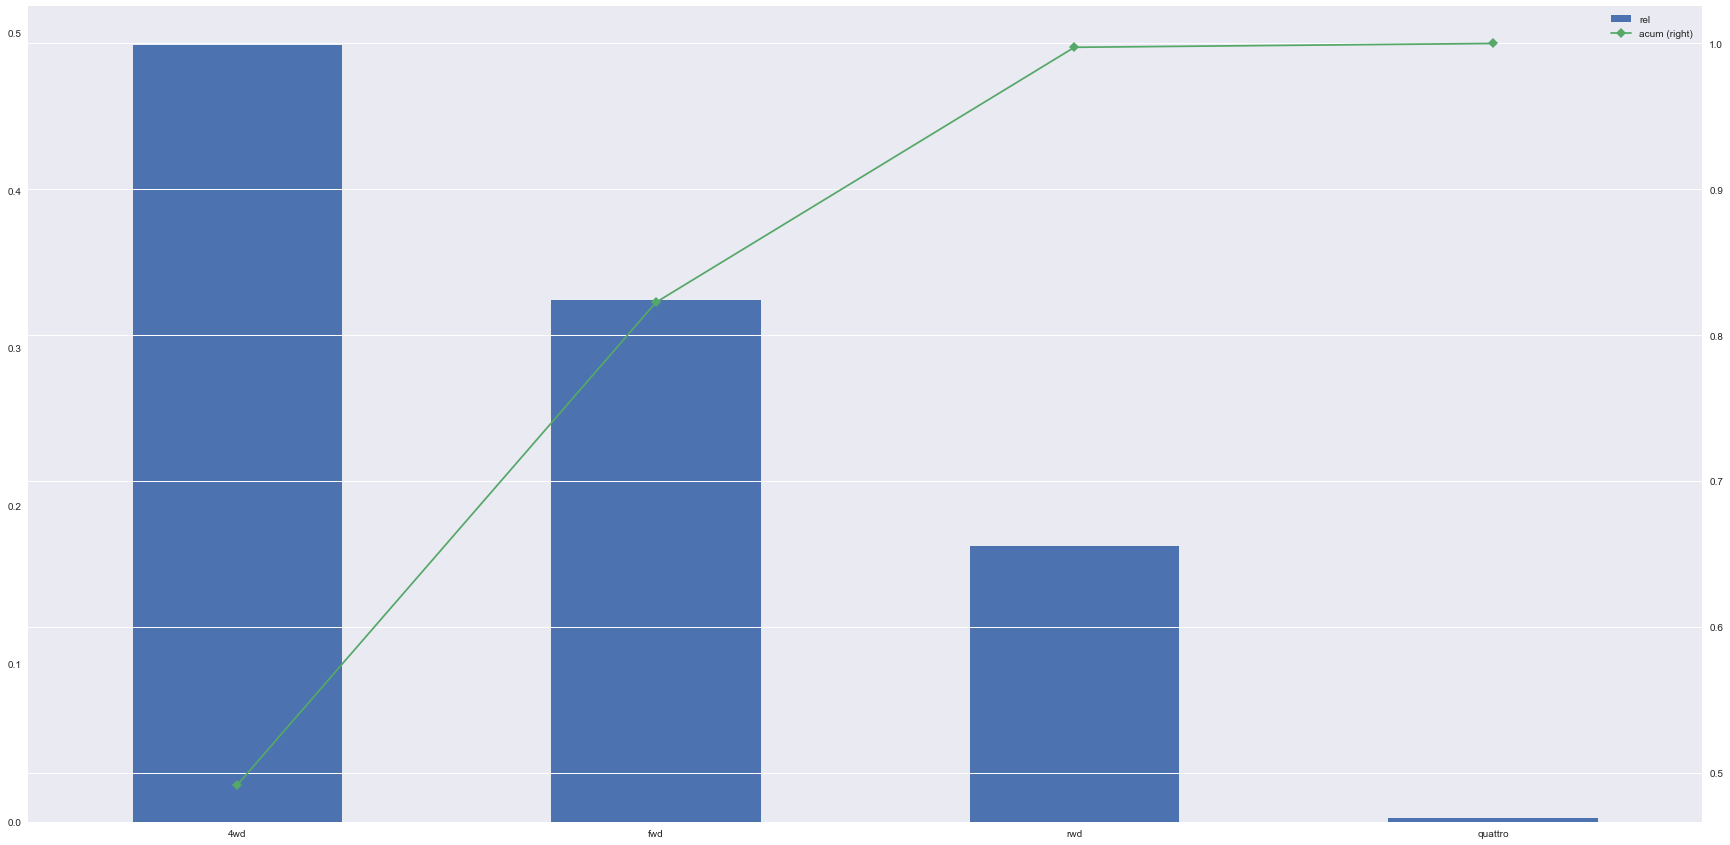

**----------**
Columan : type


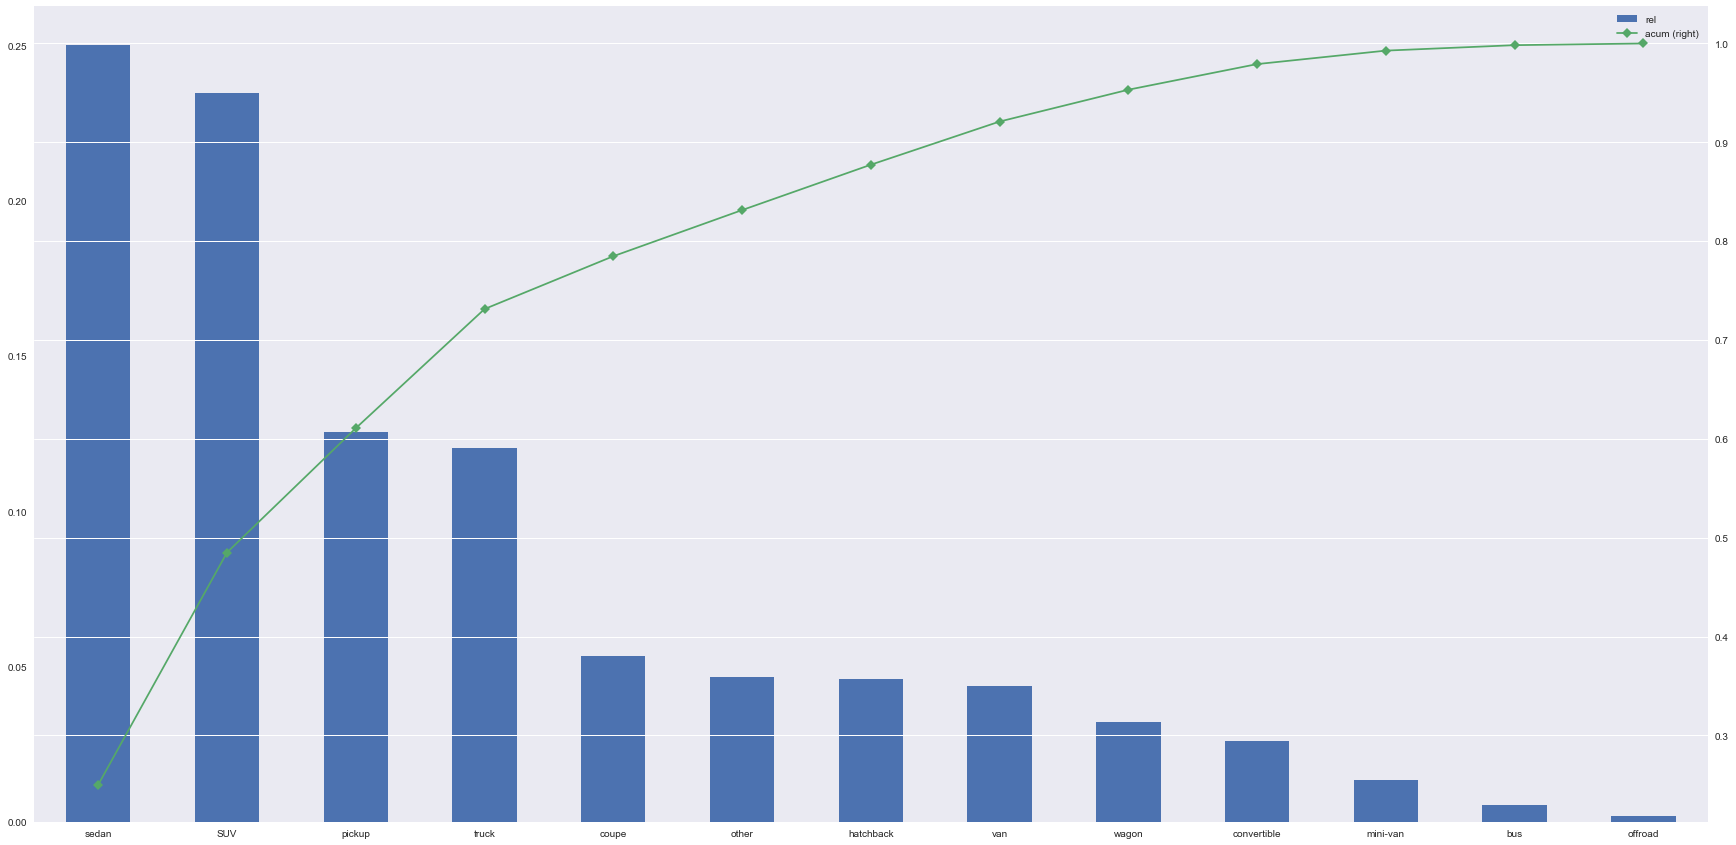

**----------**
Columan : paint_color


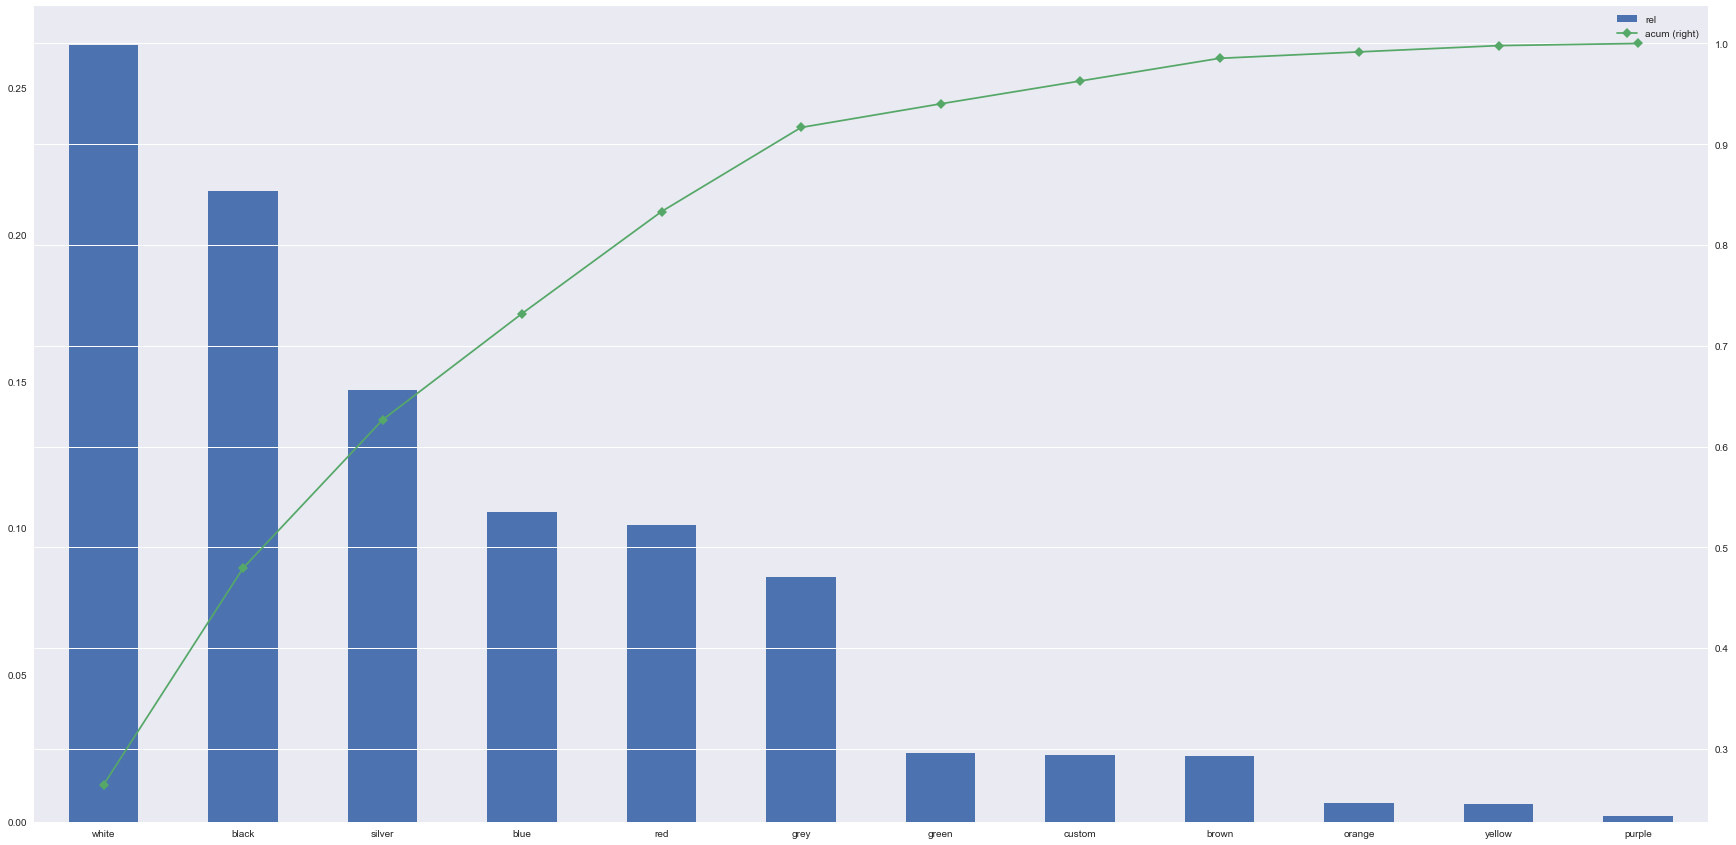

**----------**
Columan : state


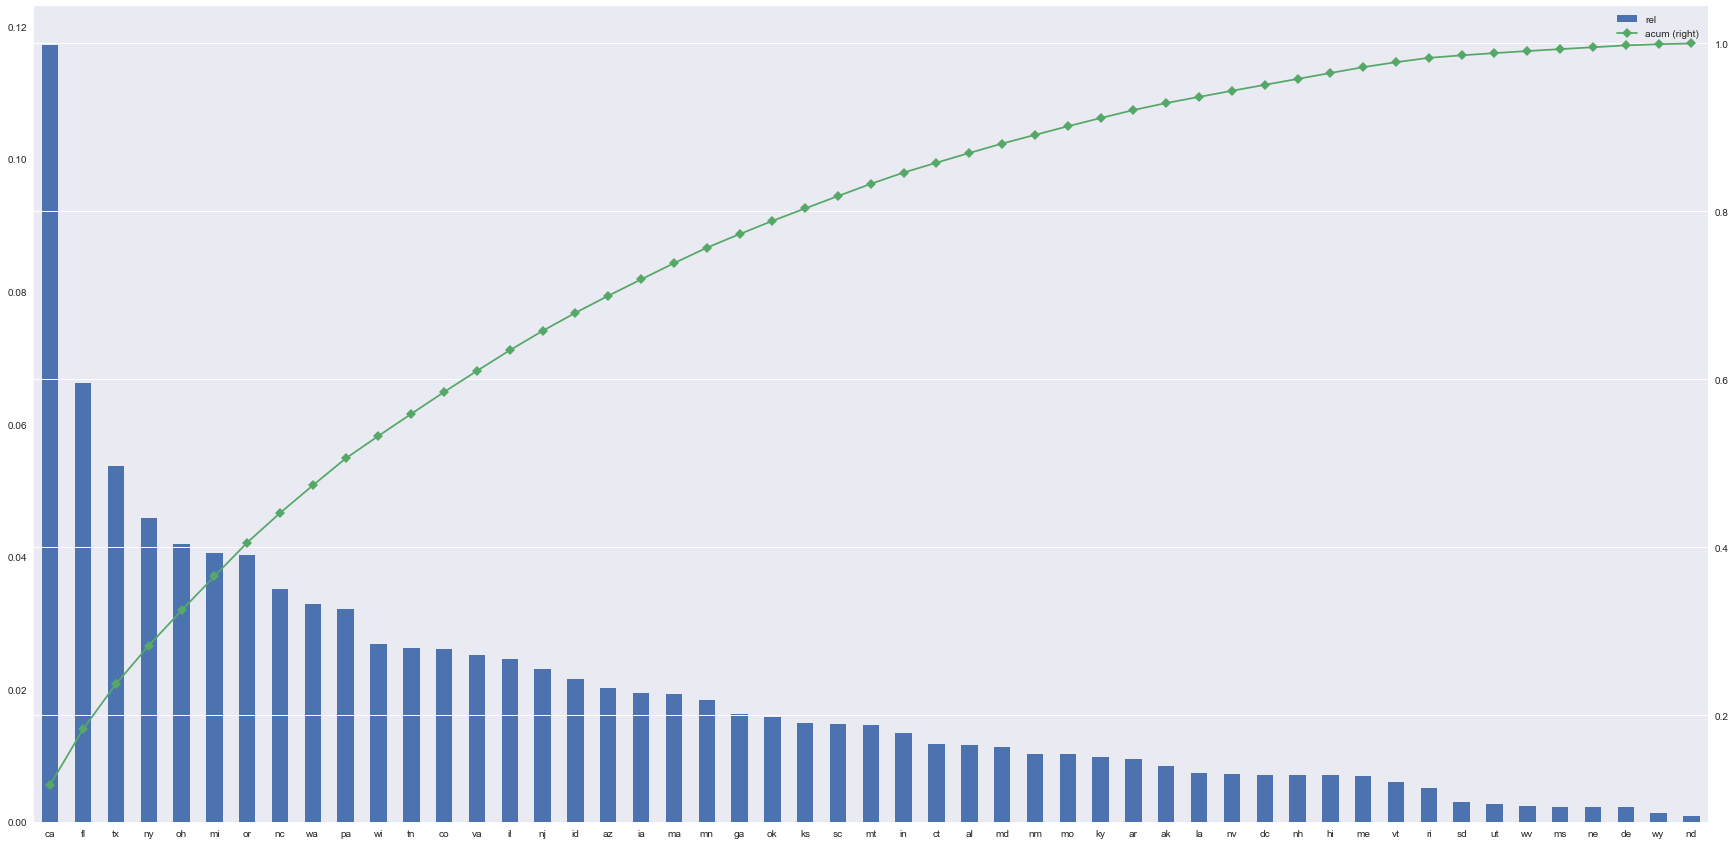

In [38]:
# no ejecutar, mucho procesamiento
for i in df_frec.keys():    
    fig, axes = plt.subplots(figsize = [30,15])
    ax1 = df_frec[i].plot(use_index=True, y='rel',  kind='bar', ax=axes)
    ax2 = df_frec[i].plot(use_index=True, y='acum', marker='D', color="C1", kind='line', ax=axes, secondary_y=True)
    print("**----------**")
    print(f"Columan : {i}")
    plt.show()

**'manufacturer'**
*   Las marcas más populares son ford, chevrolet y toyota; con un gran desbalance entre si y el resto

**'condition'**

*   Las condiciones más frecuentes son good y excellent; con un gran desbalance con el resto de las variables (se debe analizar la condicion new, a través del uso de 'year' y 'age')


**'cylinders'**

*   La cantidad de cilindros mas frecuente es 6, 4 y 8; el resto es prácticamente insignificante.

**'fuel'**

*   El tipo de combustible mas frecuente es el gas, que seria gasolina o nafta.

**'title_status'**

*   El tipo de titulo mas frecuente es dean, el resto no tiene peso alguno.

**'transmission'**

*   El tipo de transmision mas frecuente es automática, el resto de los valores se encuentran totalmente desequilibrados.

**'drive'**

*   El tipo de traccion mas frecuente es 4wd, seguida de fwd y por ultimo rwd hay un desequilibrio, pero no tan pronunciado, sobre todo entre los dos primeros valores.

**'size'**

*   El tipo de tamaño mas frecuente es full-size, mid-size posee tambien una gran importancia, el resto de los valores no.

**'type'**

*   Los tipos mas frecuentes son sedan, suv, pickup y truck.

**'state'**

*   El estado que posee mayor cantidad de publicaciones es California.

In [39]:
df.loc[(df.odometer == 0) & (df.age == 0), 'condition'] = 'new'

In [40]:
df.loc[(df.odometer == 0) & (df.age == 0), 'condition'].value_counts()

new    118
Name: condition, dtype: int64

### Análisis de Outliers

Consideraremos outlier a todo valor que se encuentre muy alejado de los valores con mayor densidad.

Valores muy alejados de la mediana son dificiles de valorizar, no solo por el hecho de ser practicamente únicos, sino por su alta variabilidad de valor de mercado, sumado a que la utilidad de modelo es ser utilizado como un cotizador de vehículos. Autos raros es muy poco frecuente que quieran ser cotizados.


#### year

/Users/sebastian/miniforge3/envs/CoderHouse/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


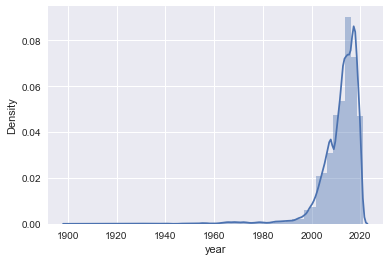

In [41]:
sns.distplot(df["year"])
plt.show()

La variable year pose la mayor acumulación de densidad entre los años 1990 y 2020. 

##### 1.5 Distancia intercuartílica

Consideramos outlier a todo dato que se encuentre 1.5 veces a la distancia intercuartilica de la mediana.

In [42]:
index_dic['year']

{'mask': array([ True,  True,  True, ...,  True,  True,  True]),
 'max': 2021.0,
 'min': 2003.0,
 'Datos_acumulados': 0.9183036038041127}

/Users/sebastian/miniforge3/envs/CoderHouse/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


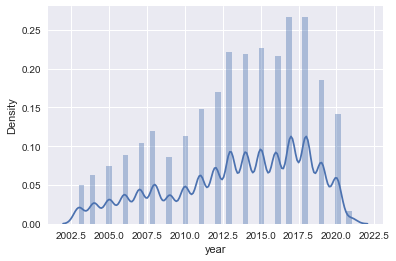

In [43]:
sns.distplot(df[index_dic['year']['mask']]['year'])
plt.show()

#### price

/Users/sebastian/miniforge3/envs/CoderHouse/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

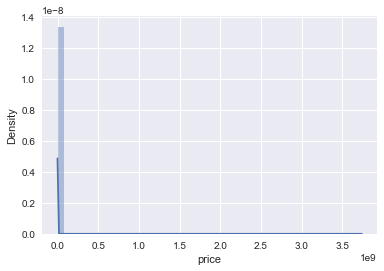

In [44]:
sns.distplot(df["price"])

Observamos al igual que en el caso de 'price', hay datos muy alejados de la mediana y con muy poca frecuencia.
La causa son posibles errores a la hora de colocar el precio en la publicación o vehiculos extremadamente caros y poco comunes.

##### 1.5 Distancia intercuartílica


Consideramos outlier todo dato que se encuentre 1.5 veces a la distancia intercuartilica de la mediana. 

In [45]:
index_dic['price']

{'mask': array([ True,  True,  True, ...,  True,  True,  True]),
 'max': 44883,
 'min': 0,
 'Datos_acumulados': 0.95329633917921}

/Users/sebastian/miniforge3/envs/CoderHouse/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

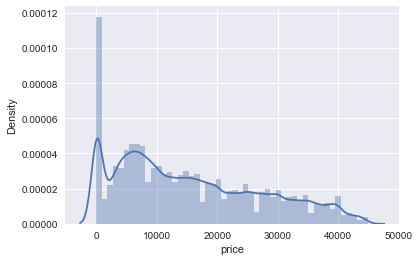

In [46]:
sns.distplot(df[index_dic['price']['mask']]['price'])

Por haber una gran dispersión por valores extremadamente elevados, la lógica de 1.5 a la distancia intercuartilica no elimina los valores '0', que son valores indeseados.

### price == 0
límite
* 1000
* 2000
* 3000

In [47]:
df_out = df[(df['price'] > 1000) & (df['price'] < 44800)]['price'].shape[0]/df['price'].notnull().sum()

In [48]:
df[(df['price'] > 2000) & (df['price'] < 44800)]['price'].shape[0]/df['price'].notnull().sum()

0.832998652105741

In [49]:
df[(df['price'] > 3000) & (df['price'] < 44800)]['price'].shape[0]/df['price'].notnull().sum()

0.8075287021453775

Utilizamos 3 límites inferiores y calculamos la cantidad de datos que nos quedan.


### odometer

Consideramos outlier todo dato que se encuentre a 1.5 veces la distancia intercuartilica de la mediana

/Users/sebastian/miniforge3/envs/CoderHouse/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='odometer', ylabel='Density'>

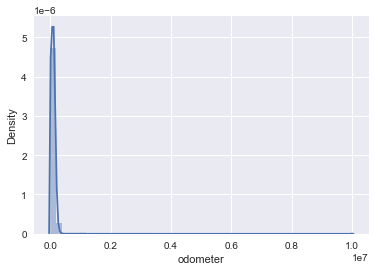

In [50]:
sns.distplot(df["odometer"])

#### 1.5 Distancia intercuartílica

In [51]:
index_dic['odometer']

{'mask': array([ True,  True,  True, ...,  True,  True,  True]),
 'max': 227957.0,
 'min': 0.0,
 'Datos_acumulados': 0.9740449081356297}

/Users/sebastian/miniforge3/envs/CoderHouse/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='odometer', ylabel='Density'>

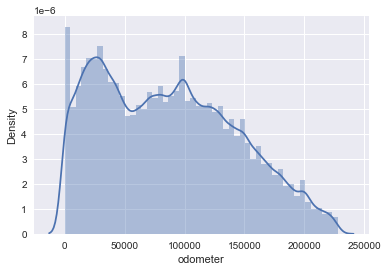

In [52]:
sns.distplot(df[index_dic['odometer']['mask']]['odometer'])

En este caso podemos encontrarnos con vehículos de poco kilometraje, que serán nuevos o semi nuevos

### Outlier

In [53]:
df_out = df[(index_dic['price']['mask'] & (df['price'] > 1000)) & (index_dic['odometer']['mask'] & (index_dic['year']['mask']))]

In [54]:
(df_out.notnull().sum()/df.notnull().sum()).sort_values()

cylinders       0.751212
fuel            0.758137
transmission    0.758660
region          0.758772
price           0.758772
year            0.758772
manufacturer    0.758772
model           0.758772
odometer        0.758772
state           0.758772
age             0.758772
title_status    0.759265
drive           0.762952
type            0.769237
paint_color     0.782913
condition       0.798571
dtype: float64

Quitando outliers, removemos entre el 20% y el 25% de los datos por columna.

In [55]:
(df_out.notnull().sum()/df.shape[0]).sort_values()

condition       0.474911
cylinders       0.525379
paint_color     0.549306
drive           0.578719
type            0.651538
title_status    0.745646
fuel            0.754648
transmission    0.755714
region          0.758772
price           0.758772
year            0.758772
manufacturer    0.758772
model           0.758772
odometer        0.758772
state           0.758772
age             0.758772
dtype: float64

In [56]:
(df_out.notnull().sum()/df_out.shape[0]).sort_values()

condition       0.625895
cylinders       0.692407
paint_color     0.723940
drive           0.762705
type            0.858674
title_status    0.982701
fuel            0.994565
transmission    0.995969
region          1.000000
price           1.000000
year            1.000000
manufacturer    1.000000
model           1.000000
odometer        1.000000
state           1.000000
age             1.000000
dtype: float64

Reevaluamos la cantidad de notnull. No hay gran variación con respecto al dataframe original.


## Análisis Bivariado

### Con outliers vs sin Outliers

#### Price VS Categóricas

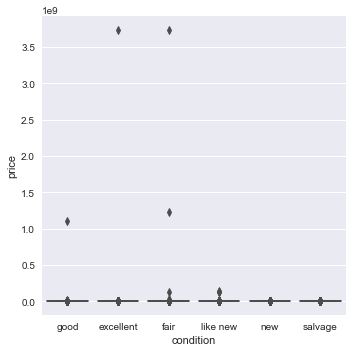

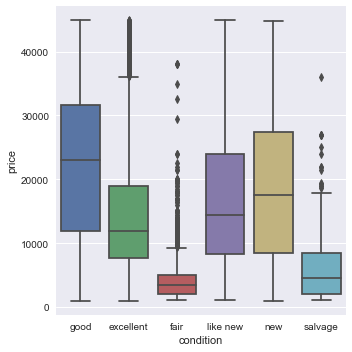

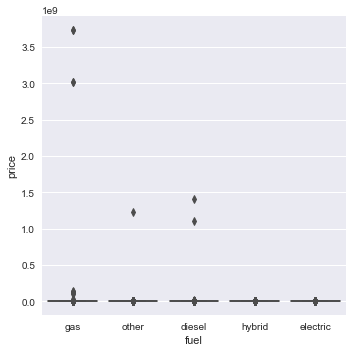

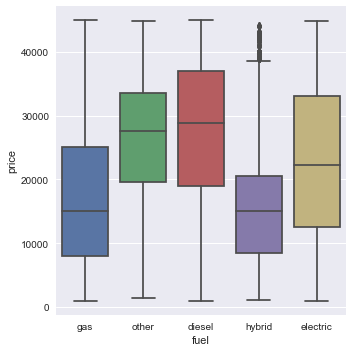

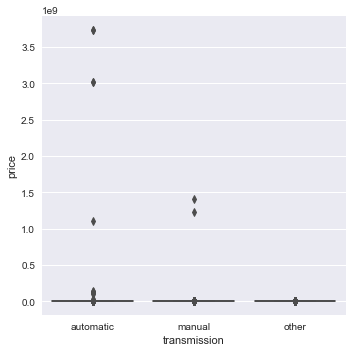

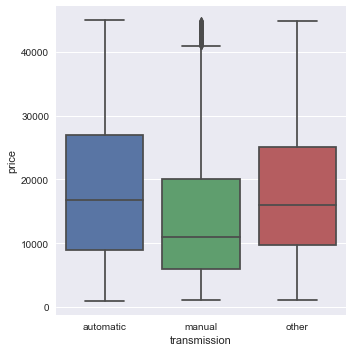

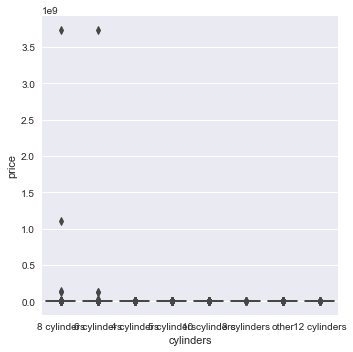

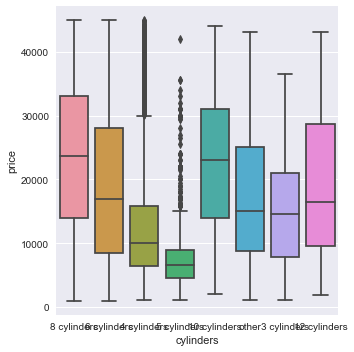

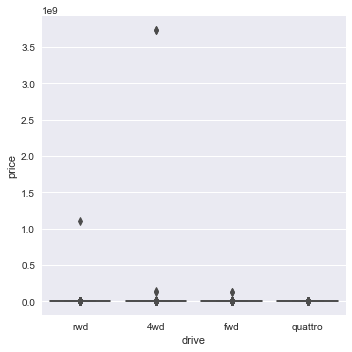

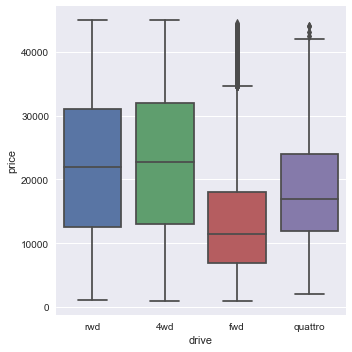

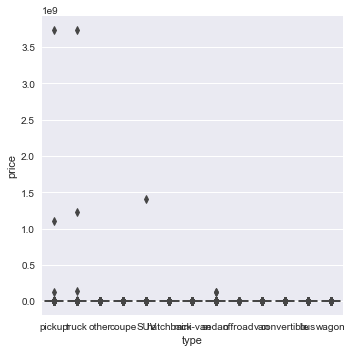

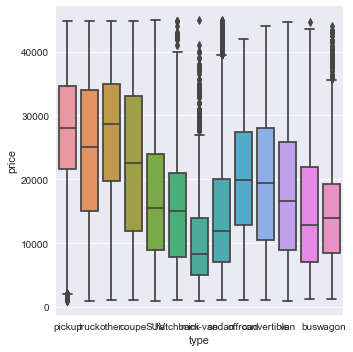

In [57]:
lista = ['condition', 'fuel', 'transmission', 'cylinders', 'drive', 'type']
for i in lista:
    sns.catplot(x = i, y = 'price', data = df, kind = "box")
    plt.show()
    print("")
    sns.catplot(x = i, y = 'price', data = df_out, kind = "box")
    plt.show()
    print("")

#### Odometer VS Categóricas

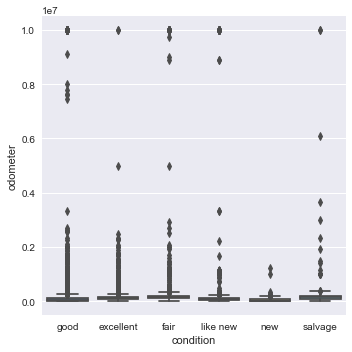

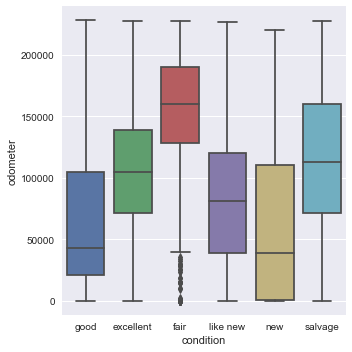

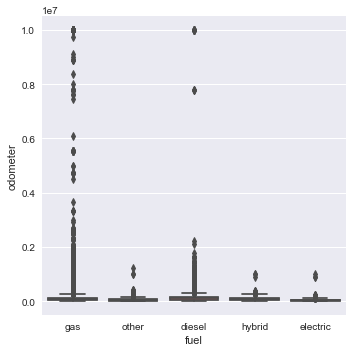

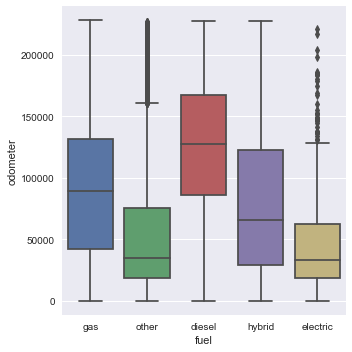

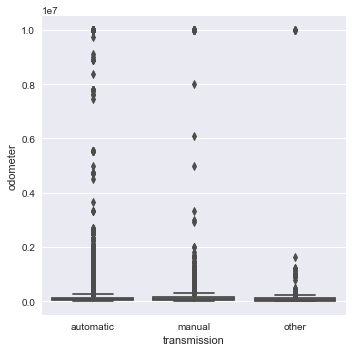

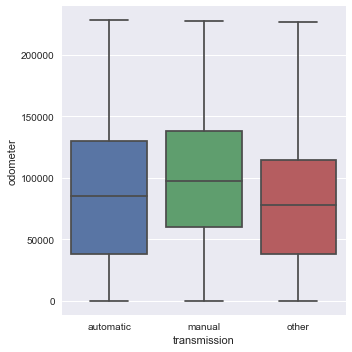

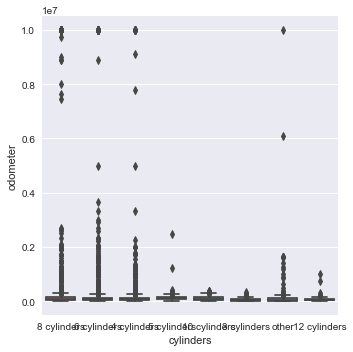

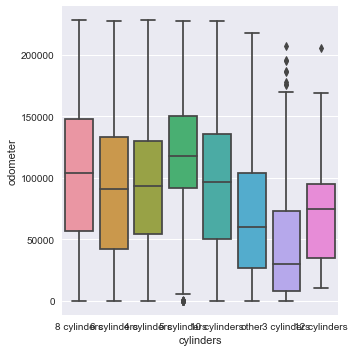

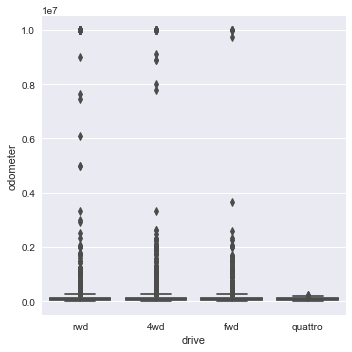

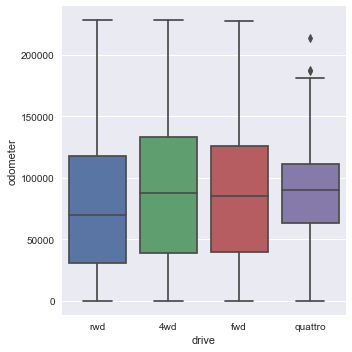

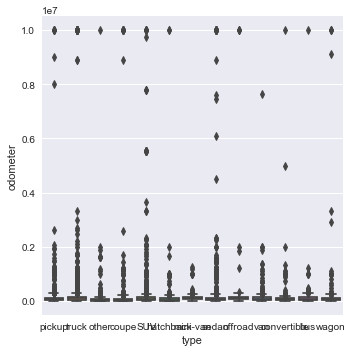

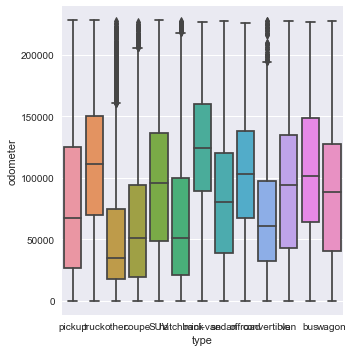

In [58]:
for i in lista:
    sns.catplot(x = i, y = 'odometer', data = df, kind = "box")
    plt.show()
    print("")
    sns.catplot(x = i, y = 'odometer', data = df_out, kind = "box")
    plt.show()
    print("")

#### Price Vs Odometer

<AxesSubplot:xlabel='price', ylabel='odometer'>

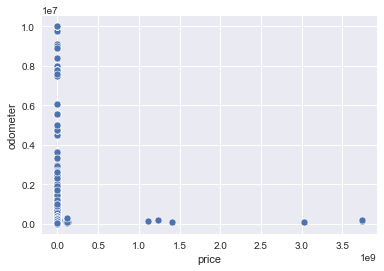

In [59]:
sns.scatterplot(data = df, x='price', y='odometer')

<AxesSubplot:xlabel='price', ylabel='odometer'>

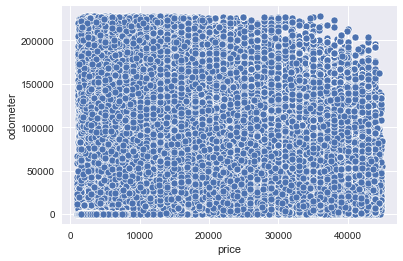

In [60]:
sns.scatterplot(data = df_out, x='price', y='odometer')

#### Precios promedio por marca de fabricante

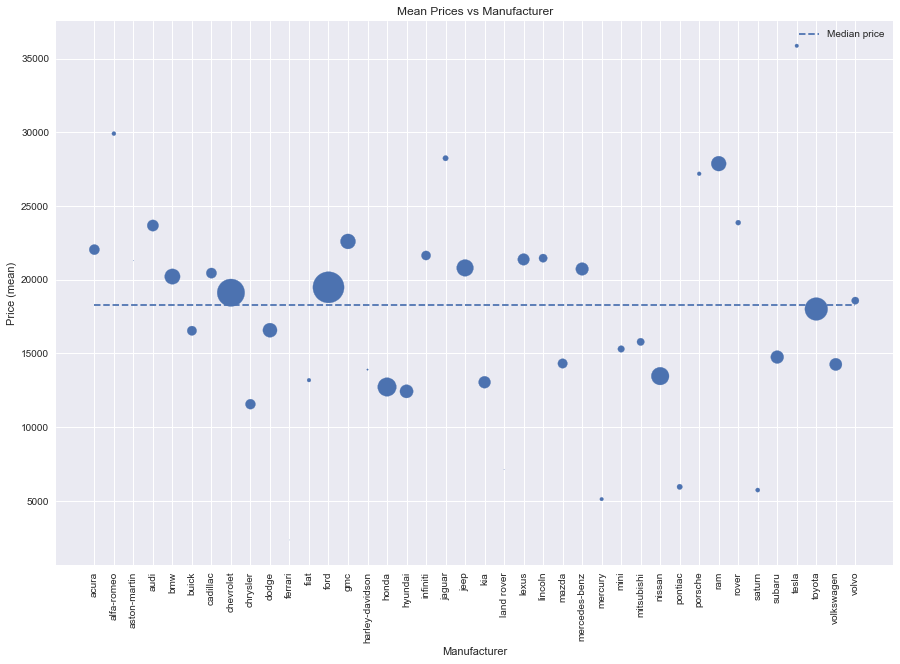

In [61]:
grp_man_df = df_out.groupby(by='manufacturer').mean()['price'].reset_index()

x = grp_man_df.manufacturer
y = grp_man_df.price
y_mean = [np.median(y)]*len(grp_man_df)


f, ax = plt.subplots(figsize=(15, 10))
ax.scatter(x, y, s=df_out['manufacturer'].value_counts().sort_index()/50)
ax.plot(x, y_mean, label='Median price', linestyle='--')

plt.title(f"Mean Prices vs Manufacturer")
plt.ylabel("Price (mean)")
plt.xlabel("Manufacturer")
plt.xticks(rotation=90)
plt.legend()
plt.show()

Podemos ver que, mayormente, la variacián de los promedios de los precios por marca es de $7000.

Además, encontramos marcas que poseen preciod que no deberian, o algún otro tipo de inconsistencia.


*   Ferrari
*   Harley-Davidson





In [62]:
df_out = df_out.drop(df_out.loc[(df_out['manufacturer'] == 'ferrari') | (df_out['manufacturer'] == 'harley-davidson')].index)

### Corelation

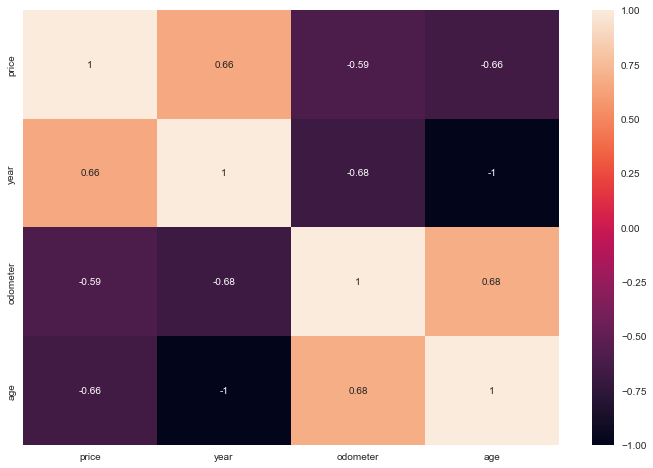

In [63]:
plt.figure(figsize=(12, 8))

df_corr = df_out.corr()
sns.heatmap(df_corr, 
            xticklabels = df_corr.columns.values,
            yticklabels = df_corr.columns.values,
            annot = True);

Analizamos la correlacion de las variables con price y entre si, para ver si encontramos Multicolinealidad

Hay colinealidad entre year y age

gmc


/var/folders/2c/3dzcy1r97qqf84vj6j5nvf6m0000gn/T/ipykernel_2351/2668390281.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_corr = df_out[df.manufacturer == i].corr()


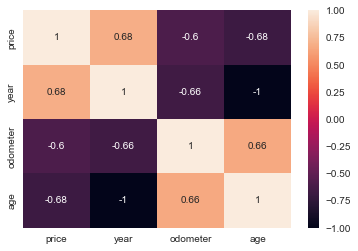

chevrolet


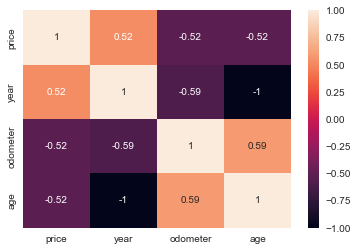

toyota


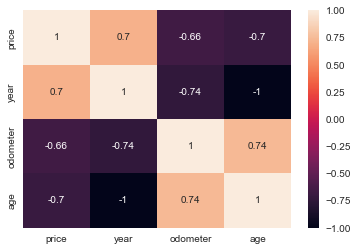

ford


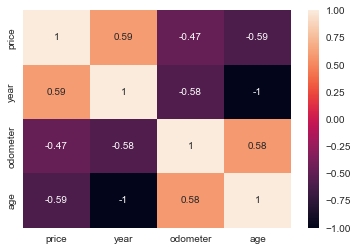

jeep


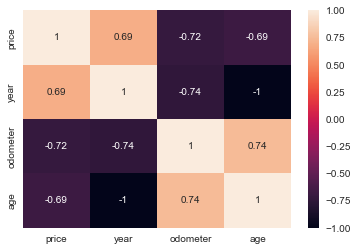

nissan


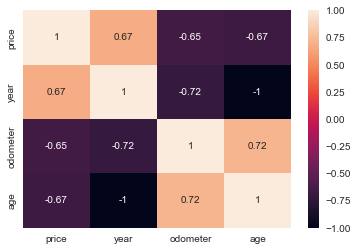

ram


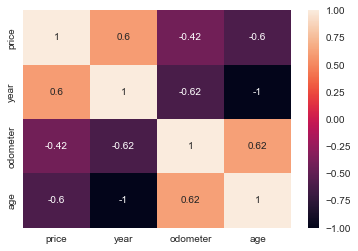

mazda


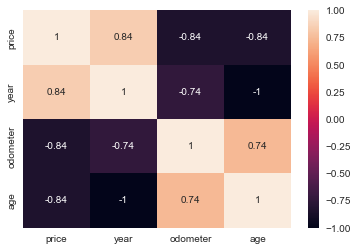

cadillac


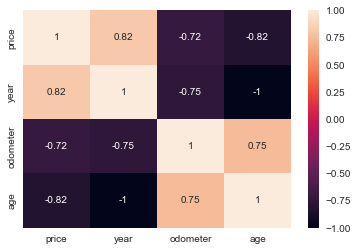

honda


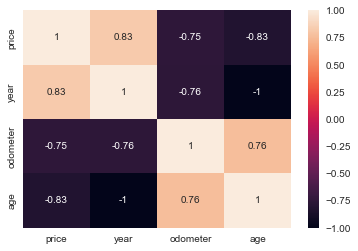

dodge


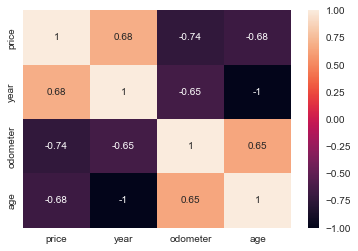

lexus


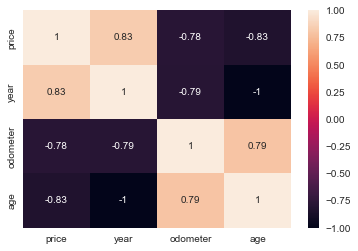

jaguar


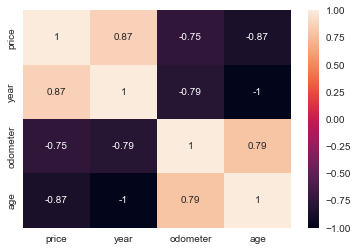

buick


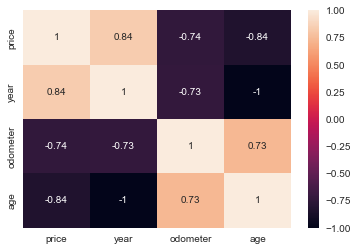

chrysler


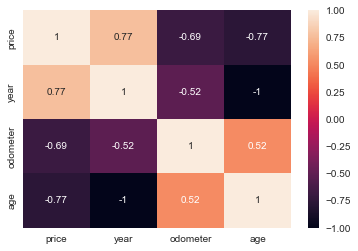

volvo


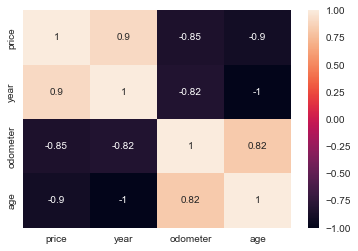

audi


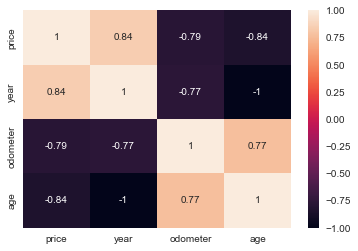

infiniti


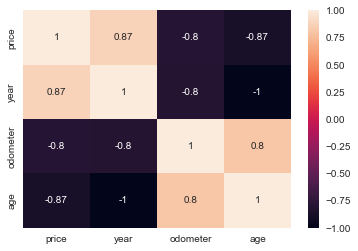

lincoln


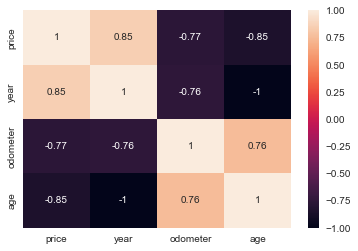

alfa-romeo


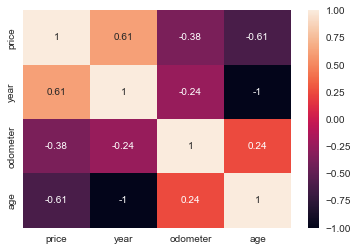

subaru


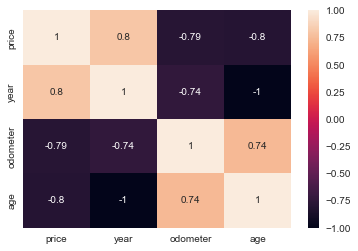

acura


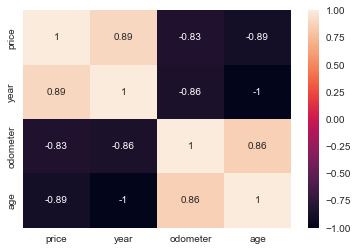

hyundai


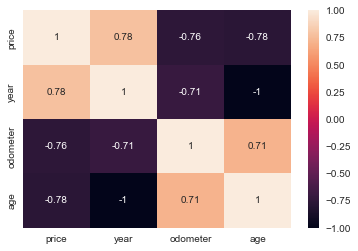

mercedes-benz


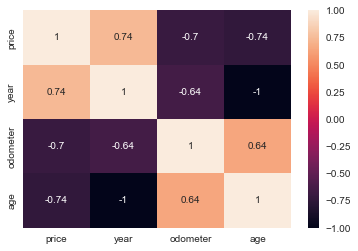

bmw


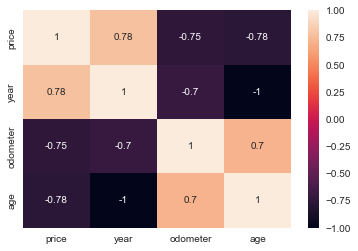

mitsubishi


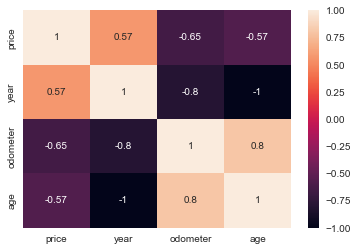

volkswagen


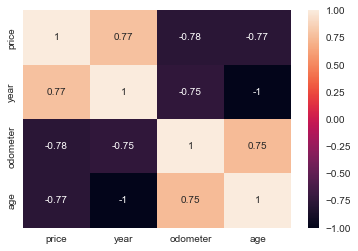

porsche


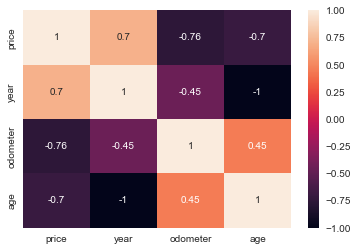

kia


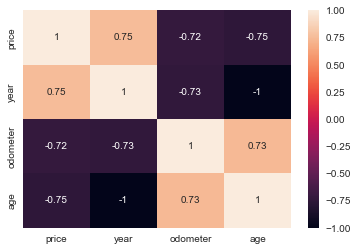

mini


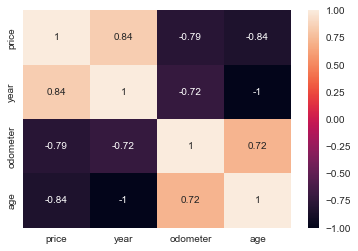

pontiac


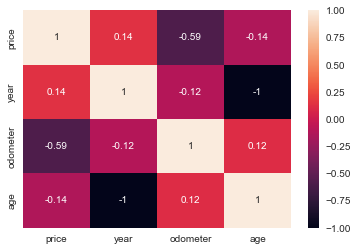

fiat


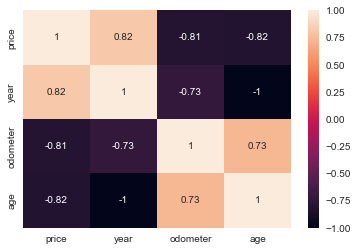

rover


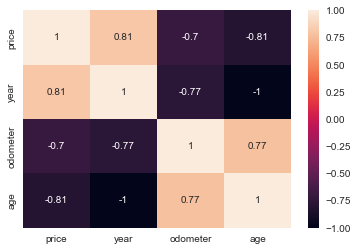

tesla


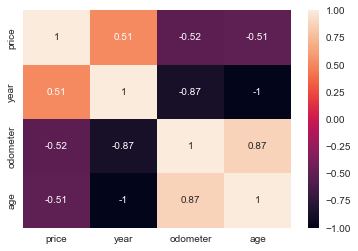

saturn


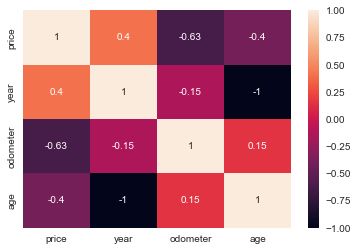

mercury


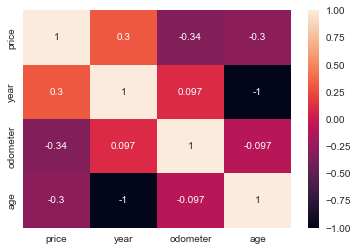

aston-martin


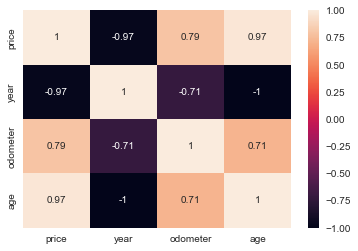

land rover


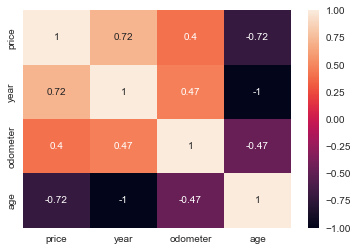

In [64]:
for i in df_out.manufacturer.unique():
    df_corr = df_out[df.manufacturer == i].corr()
    sns.heatmap(df_corr, 
            xticklabels = df_corr.columns.values,
            yticklabels = df_corr.columns.values,
            annot = True)
    print(i)
    plt.show()

## Análisis Multivariado

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 720x480 with 0 Axes>

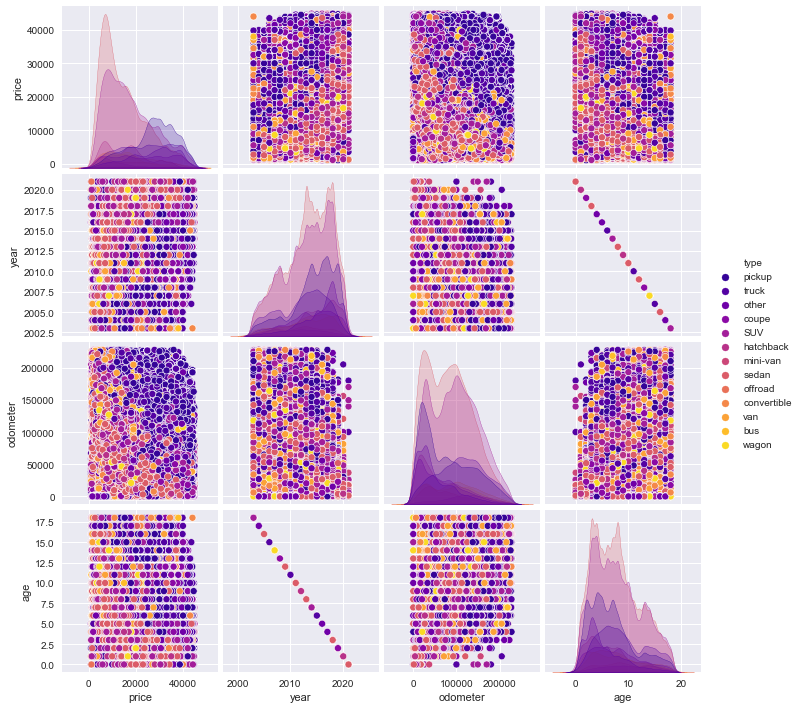

In [65]:
item_list = df.dtypes[df.dtypes != 'object'].index.to_list()
lista_appen = ['type', 'condition', 'fuel']
item_list = item_list + lista_appen
plt.figure(dpi = 120)
sns.pairplot(df_out[item_list],hue = 'type',palette = 'plasma')
plt.legend()
plt.show()

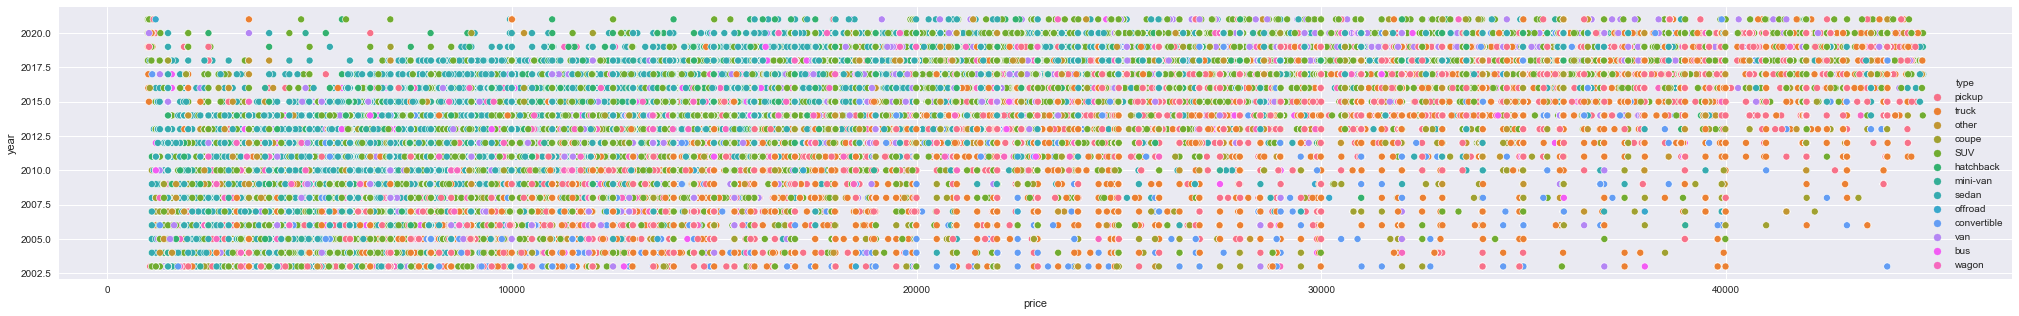

In [66]:
plt.figure(figsize=(35,5))
sns.scatterplot(data = df_out, x = 'price', y = 'year', hue ='type')
plt.show()

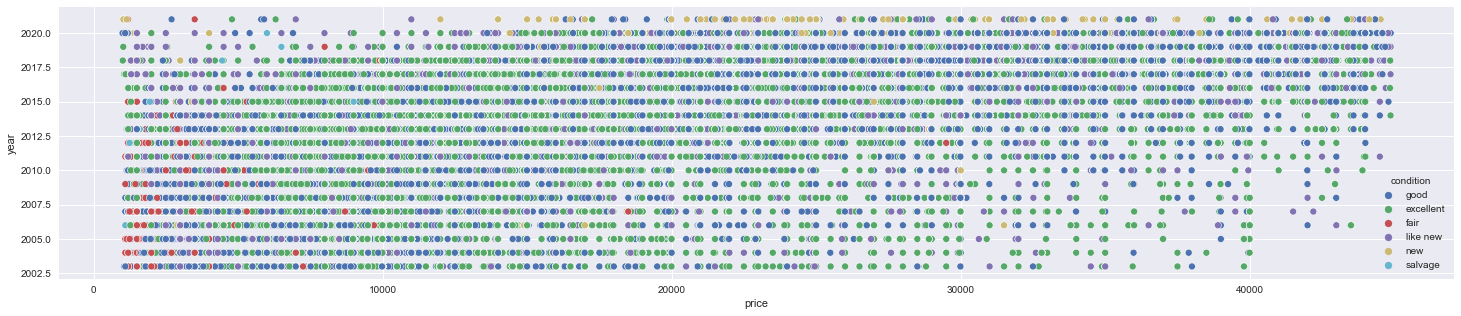

In [67]:
plt.figure(figsize=(25,5))
sns.scatterplot(data = df_out, x = 'price', y = 'year', hue ='condition')
plt.show()

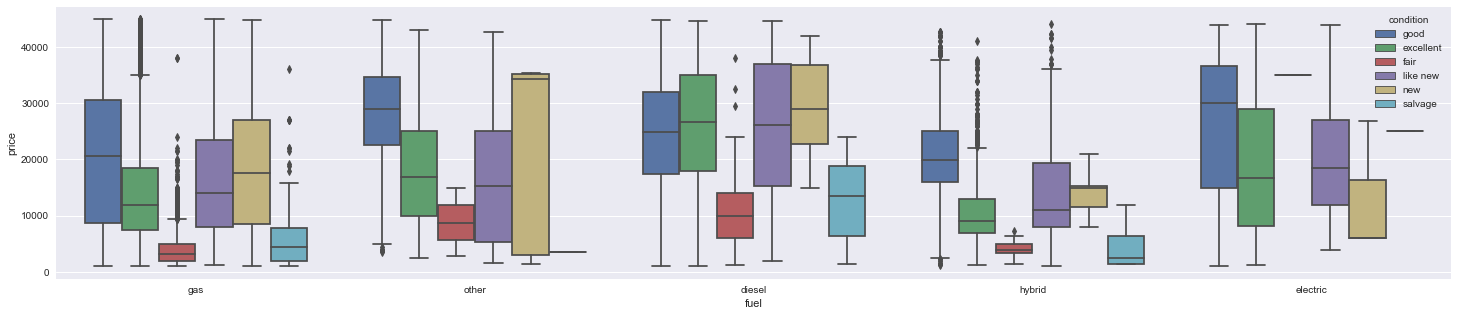

In [68]:
plt.figure(figsize=(25,5))
sns.boxplot(x='fuel',y="price",data=df_out,hue='condition')
plt.show()

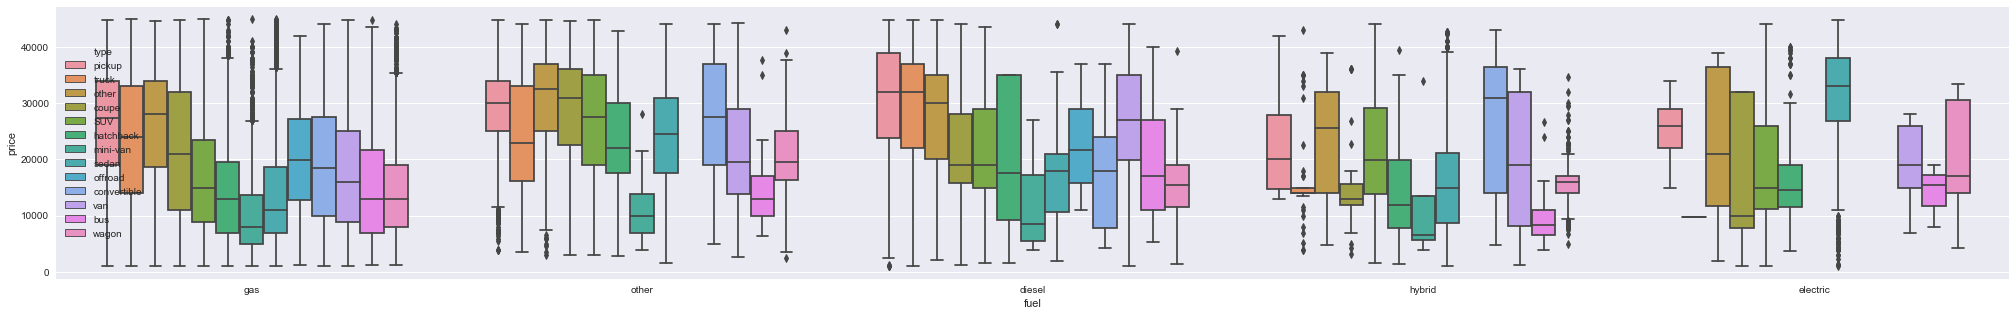

In [69]:
plt.figure(figsize=(35,5))
sns.boxplot(x='fuel',y="price",data=df_out,hue='type')
plt.show()

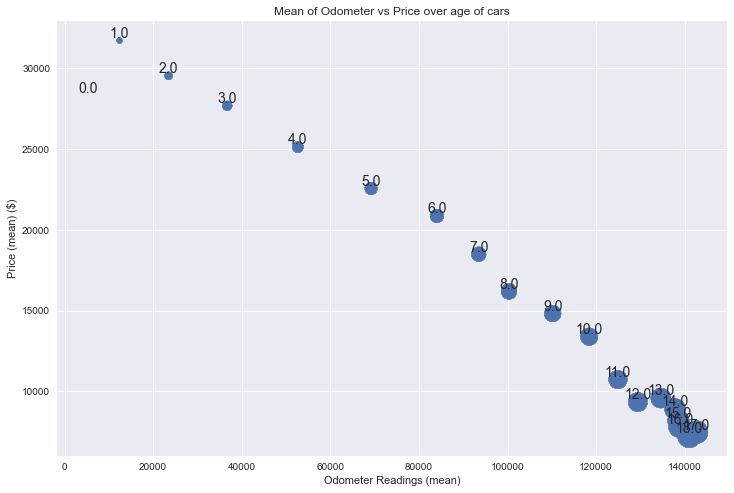

In [70]:
grp_df = df_out.groupby(by='age').mean()[['price','odometer']].astype(int).reset_index()


x = x=grp_df.odometer
y = grp_df.price
points = grp_df.age
s = [30*n for n in range(len(y))]

f, ax = plt.subplots(figsize=(12, 8))

plt.title(f"Mean of Odometer vs Price over age of cars")
plt.xlabel("Odometer Readings (mean)")
plt.ylabel("Price (mean) ($)")


for i, j in enumerate(points):
    plt.annotate(j, (x[i], y[i]), size=14, va="bottom", ha="center")
    plt.scatter(x, y, s=s)

plt.show()

In [71]:
df_out.columns

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'type', 'paint_color', 'state', 'age'],
      dtype='object')

In [72]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303313 entries, 27 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        303313 non-null  object 
 1   price         303313 non-null  int64  
 2   year          303313 non-null  float64
 3   manufacturer  303313 non-null  object 
 4   model         303313 non-null  object 
 5   condition     189851 non-null  object 
 6   cylinders     210048 non-null  object 
 7   fuel          301667 non-null  object 
 8   odometer      303313 non-null  float64
 9   title_status  298064 non-null  object 
 10  transmission  302103 non-null  object 
 11  drive         231382 non-null  object 
 12  type          260464 non-null  object 
 13  paint_color   219580 non-null  object 
 14  state         303313 non-null  object 
 15  age           303313 non-null  float64
dtypes: float64(3), int64(1), object(12)
memory usage: 47.4+ MB


In [73]:
df_out.reset_index(drop=True, inplace=True)

In [74]:
df_out.to_pickle('vehicles.pkl')


In [2]:
df_out=pd.read_pickle('vehicles.pkl')

# Modelos

## Lienal Regression 

In [3]:
df_out= df_out.applymap(lambda x : np.nan if x == 'other' else x)

In [5]:
scaler = StandardScaler()
df_pred_out = df_out[['odometer', 'year', 'age']]
scaler.fit(df_pred_out)
predictors = pd.DataFrame(scaler.transform(df_pred_out), columns=df_pred_out.columns)

In [6]:
predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303313 entries, 0 to 303312
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   odometer  303313 non-null  float64
 1   year      303313 non-null  float64
 2   age       303313 non-null  float64
dtypes: float64(3)
memory usage: 6.9 MB


In [7]:
col_list = ['odometer', 'year', 'age']
for i in col_list:    
    target=df_out['price']
    predictor= sm.add_constant(predictors[i])
    lm_1 = sm.OLS(target,predictor).fit()
    print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                 1.654e+05
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:57:53   Log-Likelihood:            -3.1896e+06
No. Observations:              303313   AIC:                         6.379e+06
Df Residuals:                  303311   BIC:                         6.379e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.837e+04     16.213   1133.141      0.0

Elimino la variables model (posee una altisima variabilidad), year & odometer (colinealidad con age), region con estado y condicion, cylinders y drive por su alta cantidad de null

In [8]:
df_lin_reg=df_out.drop(['model', 'year', 'condition','odometer', 'region', 'paint_color', 'drive', 'cylinders'], axis=1)

In [9]:
df_lin_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303313 entries, 0 to 303312
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         303313 non-null  int64  
 1   manufacturer  303313 non-null  object 
 2   fuel          278988 non-null  object 
 3   title_status  298064 non-null  object 
 4   transmission  298638 non-null  object 
 5   type          246763 non-null  object 
 6   state         303313 non-null  object 
 7   age           303313 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 18.5+ MB


In [10]:
df_lin_reg.columns

Index(['price', 'manufacturer', 'fuel', 'title_status', 'transmission', 'type',
       'state', 'age'],
      dtype='object')

In [11]:
df_lin_reg = df_lin_reg.dropna(subset=['type', 'title_status'])

In [12]:
df_lin_reg = df_lin_reg.dropna(subset=['fuel', 'transmission'])

In [13]:
df_lin_reg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218248 entries, 0 to 303312
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         218248 non-null  int64  
 1   manufacturer  218248 non-null  object 
 2   fuel          218248 non-null  object 
 3   title_status  218248 non-null  object 
 4   transmission  218248 non-null  object 
 5   type          218248 non-null  object 
 6   state         218248 non-null  object 
 7   age           218248 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 15.0+ MB


In [14]:
df_lin_reg=pd.get_dummies(df_lin_reg)

In [15]:
df_lin_reg.reset_index(drop = True, inplace = True)

In [16]:
scaler = StandardScaler()
df_pred_out = df_lin_reg.drop(['price'], axis=1)
scaler.fit(df_pred_out)
predictors = pd.DataFrame(scaler.transform(df_pred_out), columns=df_pred_out.columns)

In [17]:
#resetear indice
df_lin_reg = pd.concat([predictors, df_lin_reg['price']], join ='inner', axis =1)

In [18]:
df_cor = df_lin_reg.corr()

Analisamos la correlacion entre la variables

In [19]:
for i in df_cor.columns:    
    if not (df_cor[((df_cor[i]>.4) & (df_cor[i]<1)) | ((df_cor[i]<-.4)&(df_cor[i]>-1))][i]).empty:
        print('----------')
        print(i)
        print((df_cor[((df_cor[i]>.4) & (df_cor[i]<1)) | (df_cor[i]<-.4)][i]))

----------
age
price   -0.64564
Name: age, dtype: float64
----------
manufacturer_tesla
fuel_electric    0.576145
Name: manufacturer_tesla, dtype: float64
----------
fuel_diesel
fuel_gas   -0.781655
Name: fuel_diesel, dtype: float64
----------
fuel_electric
manufacturer_tesla    0.576145
Name: fuel_electric, dtype: float64
----------
fuel_gas
fuel_diesel   -0.781655
fuel_hybrid   -0.519731
Name: fuel_gas, dtype: float64
----------
fuel_hybrid
fuel_gas   -0.519731
Name: fuel_hybrid, dtype: float64
----------
title_status_clean
title_status_rebuilt   -0.777448
title_status_salvage   -0.500598
Name: title_status_clean, dtype: float64
----------
title_status_rebuilt
title_status_clean   -0.777448
Name: title_status_rebuilt, dtype: float64
----------
title_status_salvage
title_status_clean   -0.500598
Name: title_status_salvage, dtype: float64
----------
price
age   -0.64564
Name: price, dtype: float64


Analizamos cada unas de las correlaciones antes expuestas, para seleccionar la variable mas representativa del modelo

### manufacturer_tesla vs fuel_electric

In [20]:
predictors=df_lin_reg[['fuel_electric']]
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     383.6
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           2.47e-85
Time:                        20:58:06   Log-Likelihood:            -2.3385e+06
No. Observations:              218248   AIC:                         4.677e+06
Df Residuals:                  218246   BIC:                         4.677e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            1.8e+04     23.317    772.162

In [21]:
predictors=df_lin_reg['manufacturer_tesla']
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1436.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):          2.80e-313
Time:                        20:58:07   Log-Likelihood:            -2.3380e+06
No. Observations:              218248   AIC:                         4.676e+06
Df Residuals:                  218246   BIC:                         4.676e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 1.8e+04     23

### transmission_automatic vs transmission_manual

In [22]:
predictors=df_lin_reg['transmission_automatic']
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1078.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):          9.32e-236
Time:                        20:58:07   Log-Likelihood:            -2.3381e+06
No. Observations:              218248   AIC:                         4.676e+06
Df Residuals:                  218246   BIC:                         4.676e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     1.

In [23]:
predictors=df_lin_reg['transmission_manual']
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1078.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):          9.32e-236
Time:                        20:58:07   Log-Likelihood:            -2.3381e+06
No. Observations:              218248   AIC:                         4.676e+06
Df Residuals:                  218246   BIC:                         4.676e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  1.8e+04    

### title_status_clean vs title_status_rebuilt

In [24]:
predictors=df_lin_reg[['title_status_rebuilt', 'title_status_salvage']]
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     918.3
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:58:08   Log-Likelihood:            -2.3378e+06
No. Observations:              218248   AIC:                         4.676e+06
Df Residuals:                  218245   BIC:                         4.676e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   1.8e+04 

In [25]:
predictors=df_lin_reg['title_status_clean']
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1545.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:58:08   Log-Likelihood:            -2.3379e+06
No. Observations:              218248   AIC:                         4.676e+06
Df Residuals:                  218246   BIC:                         4.676e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 1.8e+04     23

### fuel_gas vs fuel_diesel fuel_hybrid 

In [26]:
predictors=df_lin_reg['fuel_gas']
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     5055.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:58:08   Log-Likelihood:            -2.3362e+06
No. Observations:              218248   AIC:                         4.672e+06
Df Residuals:                  218246   BIC:                         4.672e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         1.8e+04     23.072    780.369      0.0

In [27]:
predictors=df_lin_reg[['fuel_diesel', 'fuel_hybrid']]
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     3923.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:58:09   Log-Likelihood:            -2.3348e+06
No. Observations:              218248   AIC:                         4.670e+06
Df Residuals:                  218245   BIC:                         4.670e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          1.8e+04     22.929    785.227      

### drop dummies

Todos los valores que posena un p-valor mayor a 0.05 se eliminan, ya que hay alta probabilidad de que la corelacion con price sea 0

In [28]:
df_lin_reg = df_lin_reg.drop(['fuel_electric', 'transmission_automatic', 'title_status_clean', 'fuel_gas'], axis=1)

In [29]:
predictors=df_lin_reg.drop(['price'], axis =1)
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     4515.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:58:12   Log-Likelihood:            -2.2092e+06
No. Observations:              218248   AIC:                         4.419e+06
Df Residuals:                  218137   BIC:                         4.420e+06
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [30]:
df_lin_reg.drop(['state_ne'], axis=1, inplace = True)
predictors=df_lin_reg.drop(['price'], axis =1)
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     4556.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:58:16   Log-Likelihood:            -2.2092e+06
No. Observations:              218248   AIC:                         4.419e+06
Df Residuals:                  218138   BIC:                         4.420e+06
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [31]:
df_lin_reg.drop(['state_co'], axis=1, inplace = True)
predictors=df_lin_reg.drop(['price'], axis =1)
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     4598.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:58:19   Log-Likelihood:            -2.2092e+06
No. Observations:              218248   AIC:                         4.419e+06
Df Residuals:                  218139   BIC:                         4.420e+06
Df Model:                         108                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [32]:
df_lin_reg.drop(['state_sc'], axis=1, inplace = True)
predictors=df_lin_reg.drop(['price'], axis =1)
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     4641.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:58:23   Log-Likelihood:            -2.2092e+06
No. Observations:              218248   AIC:                         4.419e+06
Df Residuals:                  218140   BIC:                         4.420e+06
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [33]:
df_lin_reg.drop(['state_ut'], axis=1, inplace = True)
predictors=df_lin_reg.drop(['price'], axis =1)
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     4685.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:58:27   Log-Likelihood:            -2.2092e+06
No. Observations:              218248   AIC:                         4.419e+06
Df Residuals:                  218141   BIC:                         4.420e+06
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [34]:
df_lin_reg.drop(['state_de'], axis=1, inplace = True)
predictors=df_lin_reg.drop(['price'], axis =1)
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     4730.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:58:30   Log-Likelihood:            -2.2092e+06
No. Observations:              218248   AIC:                         4.419e+06
Df Residuals:                  218142   BIC:                         4.420e+06
Df Model:                         105                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [35]:
df_lin_reg.drop(['type_bus'], axis=1, inplace = True)
predictors=df_lin_reg.drop(['price'], axis =1)
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     4775.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:58:34   Log-Likelihood:            -2.2092e+06
No. Observations:              218248   AIC:                         4.419e+06
Df Residuals:                  218143   BIC:                         4.420e+06
Df Model:                         104                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [36]:
df_lin_reg.drop(['manufacturer_land rover'], axis=1, inplace = True)
predictors=df_lin_reg.drop(['price'], axis =1)
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     4822.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:58:37   Log-Likelihood:            -2.2092e+06
No. Observations:              218248   AIC:                         4.419e+06
Df Residuals:                  218144   BIC:                         4.420e+06
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [37]:
df_lin_reg.drop(['manufacturer_gmc'], axis=1, inplace = True)
predictors=df_lin_reg.drop(['price'], axis =1)
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     4869.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:58:41   Log-Likelihood:            -2.2092e+06
No. Observations:              218248   AIC:                         4.419e+06
Df Residuals:                  218145   BIC:                         4.420e+06
Df Model:                         102                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [38]:
df_lin_reg.drop(['manufacturer_aston-martin'], axis=1, inplace = True)
predictors=df_lin_reg.drop(['price'], axis =1)
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     4917.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:58:44   Log-Likelihood:            -2.2092e+06
No. Observations:              218248   AIC:                         4.419e+06
Df Residuals:                  218146   BIC:                         4.420e+06
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [39]:
df_lin_reg.drop(['type_van'], axis=1, inplace = True)
predictors=df_lin_reg.drop(['price'], axis =1)
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     4966.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:58:47   Log-Likelihood:            -2.2092e+06
No. Observations:              218248   AIC:                         4.419e+06
Df Residuals:                  218147   BIC:                         4.420e+06
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [40]:
df_lin_reg.drop(['manufacturer_mercury'], axis=1, inplace = True)
predictors=df_lin_reg.drop(['price'], axis =1)
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     5016.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:58:50   Log-Likelihood:            -2.2092e+06
No. Observations:              218248   AIC:                         4.419e+06
Df Residuals:                  218148   BIC:                         4.420e+06
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [41]:
df_lin_reg.drop(['state_mo'], axis=1, inplace = True)
predictors=df_lin_reg.drop(['price'], axis =1)
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     5068.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:58:53   Log-Likelihood:            -2.2092e+06
No. Observations:              218248   AIC:                         4.419e+06
Df Residuals:                  218149   BIC:                         4.420e+06
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [42]:
df_lin_reg.drop(['state_in'], axis=1, inplace = True)
predictors=df_lin_reg.drop(['price'], axis =1)
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     5120.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:58:56   Log-Likelihood:            -2.2092e+06
No. Observations:              218248   AIC:                         4.419e+06
Df Residuals:                  218150   BIC:                         4.420e+06
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [43]:
df_lin_reg.drop(['state_nv', 'state_wy'], axis=1, inplace = True)
predictors=df_lin_reg.drop(['price'], axis =1)
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     5228.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:59:00   Log-Likelihood:            -2.2092e+06
No. Observations:              218248   AIC:                         4.419e+06
Df Residuals:                  218152   BIC:                         4.420e+06
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [44]:
df_lin_reg.drop(['state_nm', 'state_ar'], axis=1, inplace = True)
predictors=df_lin_reg.drop(['price'], axis =1)
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     5340.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:59:02   Log-Likelihood:            -2.2092e+06
No. Observations:              218248   AIC:                         4.419e+06
Df Residuals:                  218154   BIC:                         4.420e+06
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [45]:
df_lin_reg.drop(['state_az', 'state_al'], axis=1, inplace = True)
predictors=df_lin_reg.drop(['price'], axis =1)
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     5457.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:59:06   Log-Likelihood:            -2.2092e+06
No. Observations:              218248   AIC:                         4.419e+06
Df Residuals:                  218156   BIC:                         4.419e+06
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [46]:
df_lin_reg.drop(['state_ga'], axis=1, inplace = True)
predictors=df_lin_reg.drop(['price'], axis =1)
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     5517.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:59:09   Log-Likelihood:            -2.2092e+06
No. Observations:              218248   AIC:                         4.419e+06
Df Residuals:                  218157   BIC:                         4.419e+06
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [47]:
df_lin_reg.drop(['state_ca'], axis=1, inplace = True)
predictors=df_lin_reg.drop(['price'], axis =1)
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     5579.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:59:12   Log-Likelihood:            -2.2092e+06
No. Observations:              218248   AIC:                         4.419e+06
Df Residuals:                  218158   BIC:                         4.419e+06
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [48]:
df_lin_reg.drop(['state_nc'], axis=1, inplace = True)
predictors=df_lin_reg.drop(['price'], axis =1)
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     5642.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:59:14   Log-Likelihood:            -2.2092e+06
No. Observations:              218248   AIC:                         4.419e+06
Df Residuals:                  218159   BIC:                         4.419e+06
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [49]:
df_lin_reg.drop(['state_nd'], axis=1, inplace = True)
predictors=df_lin_reg.drop(['price'], axis =1)
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     5707.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:59:18   Log-Likelihood:            -2.2092e+06
No. Observations:              218248   AIC:                         4.419e+06
Df Residuals:                  218160   BIC:                         4.419e+06
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [50]:
df_lin_reg.drop(['state_la'], axis=1, inplace = True)
predictors=df_lin_reg.drop(['price'], axis =1)
target=df_lin_reg['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     5773.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:59:20   Log-Likelihood:            -2.2092e+06
No. Observations:              218248   AIC:                         4.419e+06
Df Residuals:                  218161   BIC:                         4.419e+06
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

### Test del modelo

#### Lineal drop manual

In [51]:
models_metrics = {'Lienal_manual_drop':{'r2':[], 'Mean Absolute Error':[], 'Mean Squared Error': [], 'Root Mean Squared Error':[]}, 
                'Lienal_RFE':{'r2':[], 'Mean Absolute Error':[], 'Mean Squared Error': [], 'Root Mean Squared Error':[]},
                'Random_all':{'r2':[], 'Mean Absolute Error':[], 'Mean Squared Error': [], 'Root Mean Squared Error':[]},
                'Random_feat_impor':{'r2':[], 'Mean Absolute Error':[], 'Mean Squared Error': [], 'Root Mean Squared Error':[]},
                'Random_RFE':{'r2':[], 'Mean Absolute Error':[], 'Mean Squared Error': [], 'Root Mean Squared Error':[]}
                }

In [52]:
X = predictors.to_numpy()
y = target.to_numpy()
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
train, test = list(kfold.split(X))[0]
X_train = X[train]
X_test = X[test]
y_train = y[train]
y_test = y[test]

In [53]:
lin_mod1 = LinearRegression()
lin_mod1.fit(X_train, y_train)
models_metrics['Lienal_manual_drop']['r2'] = [lin_mod1.score(X_test, y_test), lin_mod1.score(X_train, y_train)]
print(f'Train: {lin_mod1.score(X_train, y_train)}')
print(f'Test: {lin_mod1.score(X_test, y_test)}')

Train: 0.6942140891642351
Test: 0.6966548215342941


In [54]:
y_pred = lin_mod1.predict(X_test)
y_pred_train = lin_mod1.predict(X_train)

In [55]:
models_metrics['Lienal_manual_drop']['Mean Absolute Error'] = [metrics.mean_absolute_error(y_test, y_pred), metrics.mean_absolute_error(y_train, y_pred_train)]
models_metrics['Lienal_manual_drop']['Mean Squared Error'] = [metrics.mean_squared_error(y_test, y_pred), metrics.mean_squared_error(y_train, y_pred_train)]
models_metrics['Lienal_manual_drop']['Root Mean Squared Error'] = [np.sqrt(metrics.mean_squared_error(y_test, y_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))]

In [56]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 4608.651083937285
Mean Squared Error: 36134616.87832496
Root Mean Squared Error: 6011.207605658364


In [57]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred_train))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

Mean Absolute Error: 4621.8508419654445
Mean Squared Error: 36326197.3858492
Root Mean Squared Error: 6027.121816078484


#### Lineal RFECV

In [58]:
df_rfe=df_out.drop(['model','condition', 'region', 'paint_color', 'drive', 'cylinders'], axis=1)
df_rfe = df_rfe.dropna(subset=['type', 'title_status', 'fuel', 'transmission'])
df_rfe=pd.get_dummies(df_rfe)
df_rfe.reset_index(drop = True, inplace = True)

In [59]:
scaler = StandardScaler()
df_pred_out = df_rfe.drop(['price'], axis=1)
scaler.fit(df_pred_out)
df_rfe_lineal = pd.DataFrame(scaler.transform(df_pred_out), columns=df_pred_out.columns)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(df_rfe_lineal, df_rfe['price'], random_state=1010)
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True), y_train.reset_index(drop=True), y_test.reset_index(drop=True)

In [61]:
rfecv = RFECV(
    estimator=LinearRegression(),
    min_features_to_select= 1,
    step =5,
    n_jobs=-1,
    scoring='r2',
    cv=kfold)

_=rfecv.fit(X_train,y_train )
print(rfecv.score(X_train,y_train))
print(rfecv.score(X_test,y_test))


/Volumes/KINGSTON/Sebastian/DataScience/CoderHouse/ProyectoFinal/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Volumes/KINGSTON/Sebastian/DataScience/CoderHouse/ProyectoFinal/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Volumes/KINGSTON/Sebastian/DataScience/CoderHouse/ProyectoFinal/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Volumes/KINGSTON/Sebastian/DataScience/CoderHouse/ProyectoFinal/lib/python3.10/site-pac

0.7368317543095335
0.7352422732167239


In [62]:
models_metrics['Lienal_RFE']['r2'] = [rfecv.score(X_test, y_test), rfecv.score(X_train, y_train)]

In [63]:
y_pred = rfecv.predict(X_test)
y_pred_train = rfecv.predict(X_train)

In [64]:
models_metrics['Lienal_RFE']['Mean Absolute Error'] = [metrics.mean_absolute_error(y_test, y_pred), metrics.mean_absolute_error(y_train, y_pred_train)]
models_metrics['Lienal_RFE']['Mean Squared Error'] = [metrics.mean_squared_error(y_test, y_pred), metrics.mean_squared_error(y_train, y_pred_train)]
models_metrics['Lienal_RFE']['Root Mean Squared Error'] = [np.sqrt(metrics.mean_squared_error(y_test, y_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))]

In [65]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 4265.034195804535
Mean Squared Error: 31478158.610006467
Root Mean Squared Error: 5610.539957081356


In [66]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred_train))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

Mean Absolute Error: 4250.268094592634
Mean Squared Error: 31277783.553665195
Root Mean Squared Error: 5592.654428235773


#### Polinomica RFECV

In [135]:
cols_poli = [col for col in X_train.columns[rfecv.support_] if '_' not in col]
cols_dummy = [col for col in X_train.columns[rfecv.support_] if '_' in col]

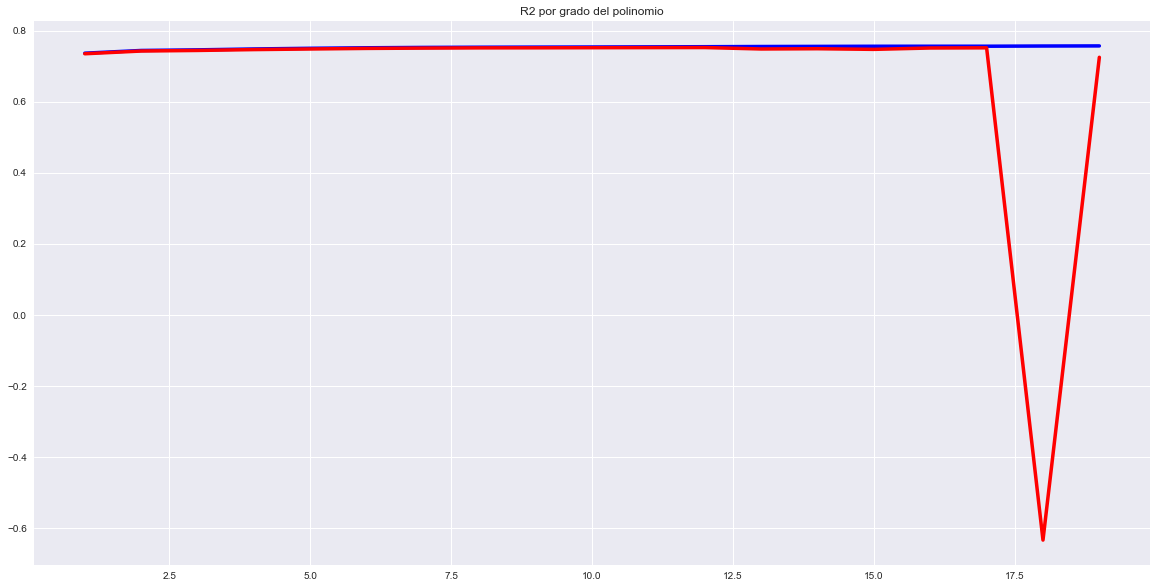

In [136]:
coef_train = []
coef_test = []
x = []
for i in range(1,20,1):
    polinomial = PolynomialFeatures(degree=i, include_bias=False)
    polinomial.fit(X_train[cols_poli])
    x_train_pol = pd.DataFrame(polinomial.transform(X_train[cols_poli]), columns=polinomial.get_feature_names_out())
    x_train_pol = pd.concat([x_train_pol, X_train[cols_dummy]], axis=1)
    x_test_pol = pd.DataFrame(polinomial.transform(X_test[cols_poli]), columns=polinomial.get_feature_names_out())
    x_test_pol = pd.concat([x_test_pol, X_test[cols_dummy]], axis=1)
    lin_mod2 = LinearRegression()
    lin_mod2.fit(x_train_pol, y_train)
    coef_train.append(lin_mod2.score(x_train_pol, y_train))
    coef_test.append(lin_mod2.score(x_test_pol, y_test))
    x.append(i)
plt.figure(figsize=(20,10))
plt.plot(x,coef_train, color="blue", linewidth=3.5, linestyle="-")
plt.plot(x,coef_test, color="red", linewidth=3.5, linestyle="-")
plt.title('R2 por grado del polinomio')
plt.show()

##### Conclusion

No hay grandes diferencias entre los algoritmos polinomicos y lineales

## Random Forest

### Mayor cantidad de datos

In [67]:
df_randfor_reg = df_out.drop(['condition', 'region', 'drive', 'cylinders', 'paint_color'], axis=1)

In [68]:
df_randfor_reg = df_randfor_reg.dropna(subset = ['type', 'fuel', 'title_status', 'transmission'])

In [69]:
df_randfor_reg=pd.get_dummies(df_randfor_reg)

In [82]:
x_train, x_test, y_train, y_test = train_test_split(df_randfor_reg.drop(['price'], axis = 1), df_randfor_reg['price'], random_state=1010)
x_train, x_test, y_train, y_test = x_train.reset_index(drop=True), x_test.reset_index(drop=True), y_train.reset_index(drop=True), y_test.reset_index(drop=True)

In [84]:
#sin normalizar 
model = RandomForestRegressor(random_state=1, n_estimators = 10, min_samples_split = 5)
model.fit(x_train, y_train)

RandomForestRegressor(min_samples_split=5, n_estimators=10, random_state=1)

In [85]:
models_metrics['Random_all']['r2'] = [model.score(x_test, y_test), model.score(x_train, y_train)]

In [86]:
print(f'Train: {model.score(x_train, y_train)}')
print(f'Test: {model.score(x_test, y_test)}')

Train: 0.9824507157100523
Test: 0.9201139590749975


In [87]:
fea_imoprt = pd.DataFrame(
    zip(x_train.columns, abs(model.feature_importances_)),
    columns=['features', 'weight']
    ).sort_values('weight').reset_index(drop=True)
feature = fea_imoprt[fea_imoprt['weight'] > .00001]['features']

In [88]:
y_pred = model.predict(x_test)
y_pred_train = model.predict(x_train)

In [89]:
models_metrics['Random_all']['Mean Absolute Error'] = [metrics.mean_absolute_error(y_test, y_pred), metrics.mean_absolute_error(y_train, y_pred_train)]
models_metrics['Random_all']['Mean Squared Error'] = [metrics.mean_squared_error(y_test, y_pred), metrics.mean_squared_error(y_train, y_pred_train)]
models_metrics['Random_all']['Root Mean Squared Error'] = [np.sqrt(metrics.mean_squared_error(y_test, y_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))]

In [77]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1638.6548083036057
Mean Squared Error: 9497987.074881999
Root Mean Squared Error: 3081.8804446120225


In [90]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred_train))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

Mean Absolute Error: 749.1906141836448
Mean Squared Error: 2085748.2790242552
Root Mean Squared Error: 1444.2119924111748


In [91]:
model_1 = RandomForestRegressor(random_state=1, n_estimators = 10, min_samples_split = 5)
model_1.fit(x_train[feature], y_train)

RandomForestRegressor(min_samples_split=5, n_estimators=10, random_state=1)

In [92]:
model_1.score(x_train[feature], y_train)


0.9812283620995909

In [93]:
model_1.score(x_test[feature], y_test)

0.9184270640374962

In [94]:
y_pred = model_1.predict(x_test[feature])
y_pred_train = model_1.predict(x_train[feature])

In [96]:
models_metrics['Random_feat_impor']['r2'] = [model_1.score(x_test[feature], y_test), model.score(x_train[feature], y_train)]
models_metrics['Random_feat_impor']['Mean Absolute Error'] = [metrics.mean_absolute_error(y_test, y_pred), metrics.mean_absolute_error(y_train, y_pred_train)]
models_metrics['Random_feat_impor']['Mean Squared Error'] = [metrics.mean_squared_error(y_test, y_pred), metrics.mean_squared_error(y_train, y_pred_train)]
models_metrics['Random_feat_impor']['Root Mean Squared Error'] = [np.sqrt(metrics.mean_squared_error(y_test, y_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))]

#### Conclusion

### RFECV

In [97]:
X_train, X_test, y_train, y_test = train_test_split(df_rfe_lineal, df_rfe['price'], random_state=1010)
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True), y_train.reset_index(drop=True), y_test.reset_index(drop=True)

In [98]:
rfecv = RFECV(
    estimator=RandomForestRegressor(random_state=1, n_estimators = 1),
    min_features_to_select= 1,
    step =5,
    n_jobs=-1,
    scoring='r2',
    cv=kfold)

_=rfecv.fit(X_train,y_train )
print(rfecv.score(X_train,y_train))
print(rfecv.score(X_test,y_test))


/Volumes/KINGSTON/Sebastian/DataScience/CoderHouse/ProyectoFinal/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Volumes/KINGSTON/Sebastian/DataScience/CoderHouse/ProyectoFinal/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Volumes/KINGSTON/Sebastian/DataScience/CoderHouse/ProyectoFinal/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Volumes/KINGSTON/Sebastian/DataScience/CoderHouse/ProyectoFinal/lib/python3.10/site-pac

0.9308193593497399
0.8107208006774255


In [105]:
df_rfe_lineal.columns[rfecv.support_].shape

(86,)

In [100]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 19)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 20, num = 4)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [102]:
model_randfor_reg = RandomForestRegressor()
cv = KFold(n_splits=5, random_state=0, shuffle=True)
random_grid = {'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf}
model_2 = RandomizedSearchCV(model_randfor_reg, random_grid, n_iter=10, random_state=0, cv=cv, n_jobs= -1)
model_2.fit(X_train[df_rfe_lineal.columns[rfecv.support_]], y_train)

/Volumes/KINGSTON/Sebastian/DataScience/CoderHouse/ProyectoFinal/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Volumes/KINGSTON/Sebastian/DataScience/CoderHouse/ProyectoFinal/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Volumes/KINGSTON/Sebastian/DataScience/CoderHouse/ProyectoFinal/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 20]},
                   random_state=0)

In [106]:
X_train[df_rfe_lineal.columns[rfecv.support_]].shape

(163686, 86)

In [108]:
print(f'Train: {model_2.score(X_train[df_rfe_lineal.columns[rfecv.support_]], y_train)}')
print(f'Test: {model_2.score(X_test[df_rfe_lineal.columns[rfecv.support_]], y_test)}')

Train: 0.8914386899761588
Test: 0.8523997830581307


In [112]:
y_pred = model_2.predict(X_test[df_rfe_lineal.columns[rfecv.support_]])
y_pred_train = model_2.predict(X_train[df_rfe_lineal.columns[rfecv.support_]])

In [113]:
models_metrics['Random_RFE']['r2'] = [model_2.score(X_test[df_rfe_lineal.columns[rfecv.support_]], y_test), model_2.score(X_train[df_rfe_lineal.columns[rfecv.support_]], y_train)]
models_metrics['Random_RFE']['Mean Absolute Error'] = [metrics.mean_absolute_error(y_test, y_pred), metrics.mean_absolute_error(y_train, y_pred_train)]
models_metrics['Random_RFE']['Mean Squared Error'] = [metrics.mean_squared_error(y_test, y_pred), metrics.mean_squared_error(y_train, y_pred_train)]
models_metrics['Random_RFE']['Root Mean Squared Error'] = [np.sqrt(metrics.mean_squared_error(y_test, y_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))]

In [114]:
models_metrics

{'Lienal_manual_drop': {'r2': [0.6966548215342941, 0.6942140891642351],
  'Mean Absolute Error': [4608.651083937285, 4621.8508419654445],
  'Mean Squared Error': [36134616.87832496, 36326197.3858492],
  'Root Mean Squared Error': [6011.207605658364, 6027.121816078484]},
 'Lienal_RFE': {'r2': [0.7352422732167239, 0.7368317543095335],
  'Mean Absolute Error': [4265.034195804535, 4250.268094592634],
  'Mean Squared Error': [31478158.610006467, 31277783.553665195],
  'Root Mean Squared Error': [5610.539957081356, 5592.654428235773]},
 'Random_all': {'r2': [0.9201139590749975, 0.9824507157100523],
  'Mean Absolute Error': [1638.6548083036057, 749.1906141836448],
  'Mean Squared Error': [9497987.074881999, 2085748.2790242552],
  'Root Mean Squared Error': [3081.8804446120225, 1444.2119924111748]},
 'Random_feat_impor': {'r2': [0.9184270640374962, 0.9812283620995909],
  'Mean Absolute Error': [1676.0065368527971, 789.2919264745917],
  'Mean Squared Error': [9698549.11397355, 2231026.109006149

In [115]:
pd.DataFrame(models_metrics)

,Lienal_manual_drop,Lienal_RFE,Random_all,Random_feat_impor,Random_RFE
r2,"[0.6966548215342941, 0.6942140891642351]","[0.7352422732167239, 0.7368317543095335]","[0.9201139590749975, 0.9824507157100523]","[0.9184270640374962, 0.9812283620995909]","[0.8523997830581307, 0.8914386899761588]"
Mean Absolute Error,"[4608.651083937285, 4621.8508419654445]","[4265.034195804535, 4250.268094592634]","[1638.6548083036057, 749.1906141836448]","[1676.0065368527971, 789.2919264745917]","[2776.654757432297, 2406.931534641034]"
Mean Squared Error,"[36134616.87832496, 36326197.3858492]","[31478158.610006467, 31277783.553665195]","[9497987.074881999, 2085748.2790242552]","[9698549.11397355, 2231026.1090061497]","[17548809.98646272, 12902609.691071311]"
Root Mean Squared Error,"[6011.207605658364, 6027.121816078484]","[5610.539957081356, 5592.654428235773]","[3081.8804446120225, 1444.2119924111748]","[3114.2493660549326, 1493.661979500767]","[4189.129979657198, 3592.0202798802948]"


In [150]:
model_2.best_params_

{'n_estimators': 8,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 20}

In [ ]:
file = open('random_forest_regressor_model.pkl', 'wb')

pickle.dump(model, file)